# Comprehensive Model Development and Evaluation
## Battery RUL Prediction - Full Analysis Pipeline

This notebook provides a comprehensive analysis including:
- Cross-validation and hyperparameter tuning
- Multiple model comparison with statistical tests
- Feature engineering and ablation studies
- Model explainability and interpretability
- Business impact analysis

## Create a cross validation to find the best model for this task

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 5060 Ti


## Load the dataset

In [3]:
# Load dataset
data_path = "../datasets/preprocessed/final_df.csv"
df = pd.read_csv(data_path)
print("Dataset loaded with shape:", df.shape)
# Display first few rows of the dataset
df.head()

Dataset loaded with shape: (49181, 42)


,battery_id,cycle_index,protocol_id,discharge_capacity_ah_max,discharge_capacity_ah_mean,discharge_capacity_ah_min,charge_capacity_ah_max,charge_capacity_ah_mean,charge_capacity_ah_min,voltage_v_max,...,rolling_mean_soh_percent,rolling_std_discharge_capacity_ah_max,rolling_std_charge_capacity_ah_max,rolling_std_voltage_v_max,rolling_std_current_a_mean,rolling_std_discharge_energy_wh_max,rolling_std_charge_energy_wh_max,rolling_std_aux_temperature_1_c_mean,rolling_std_current_a_abs_mean,rolling_std_soh_percent
0,1,1,1,2.421769,0.849490,3.200319e-05,2.394174,2.115371,0.003330,4.200036,...,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,1,2.400751,0.442225,2.473989e-10,2.416324,1.819254,0.003330,4.200032,...,99.566061,0.014862,0.015662,0.000003,0.003854,0.228743,0.055605,0.524013,0.435901,0.613682
2,1,3,1,2.399412,0.442961,2.987066e-05,2.396731,1.805943,0.003330,4.200024,...,99.402985,0.012539,0.012118,0.000006,0.002735,0.187687,0.043485,0.444561,0.355911,0.517769
3,1,4,1,2.397874,0.443705,3.193769e-05,2.394747,1.803746,0.003329,4.200034,...,99.305570,0.011273,0.010610,0.000005,0.002262,0.163473,0.038482,0.387616,0.308554,0.465491
4,1,5,1,2.397038,0.443911,3.313753e-05,2.393583,1.802770,0.003329,4.200028,...,99.240217,0.010384,0.009694,0.000005,0.001984,0.146851,0.035502,0.347763,0.276177,0.428797


In [4]:
# Show updated columns
df.columns

Index(['battery_id', 'cycle_index', 'protocol_id', 'discharge_capacity_ah_max',
       'discharge_capacity_ah_mean', 'discharge_capacity_ah_min',
       'charge_capacity_ah_max', 'charge_capacity_ah_mean',
       'charge_capacity_ah_min', 'voltage_v_max', 'voltage_v_mean',
       'voltage_v_min', 'voltage_v_std', 'current_a_mean', 'current_a_std',
       'discharge_energy_wh_max', 'charge_energy_wh_max',
       'aux_temperature_1_c_mean', 'aux_temperature_1_c_max',
       'aux_temperature_1_c_min', 'aux_temperature_1_c_std',
       'current_a_abs_mean', 'soh_percent', 'rul',
       'rolling_mean_discharge_capacity_ah_max',
       'rolling_mean_charge_capacity_ah_max', 'rolling_mean_voltage_v_max',
       'rolling_mean_current_a_mean', 'rolling_mean_discharge_energy_wh_max',
       'rolling_mean_charge_energy_wh_max',
       'rolling_mean_aux_temperature_1_c_mean',
       'rolling_mean_current_a_abs_mean', 'rolling_mean_soh_percent',
       'rolling_std_discharge_capacity_ah_max',
     

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49181 entries, 0 to 49180
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   battery_id                              49181 non-null  int64  
 1   cycle_index                             49181 non-null  int64  
 2   protocol_id                             49181 non-null  int64  
 3   discharge_capacity_ah_max               49181 non-null  float64
 4   discharge_capacity_ah_mean              49181 non-null  float64
 5   discharge_capacity_ah_min               49181 non-null  float64
 6   charge_capacity_ah_max                  49181 non-null  float64
 7   charge_capacity_ah_mean                 49181 non-null  float64
 8   charge_capacity_ah_min                  49181 non-null  float64
 9   voltage_v_max                           49181 non-null  float64
 10  voltage_v_mean                          49181 non-null  fl

In [6]:
# Comprehensive Data Analysis
print("="*80)
print("COMPREHENSIVE DATA ANALYSIS")
print("="*80)

# Dataset statistics
print(f"\nDataset Shape: {df.shape}")
print(f"Total Batteries: {df['battery_id'].nunique()}")
print(f"Total Cycles: {len(df)}")
print(f"Date Range: {df.index.min() if hasattr(df.index, 'min') else 'N/A'} to {df.index.max() if hasattr(df.index, 'max') else 'N/A'}")

# RUL distribution analysis
print(f"\n--- RUL Distribution ---")
print(f"RUL Range: [{df['rul'].min():.2f}, {df['rul'].max():.2f}]")
print(f"RUL Mean: {df['rul'].mean():.2f}")
print(f"RUL Median: {df['rul'].median():.2f}")
print(f"RUL Std: {df['rul'].std():.2f}")
print(f"RUL Skewness: {df['rul'].skew():.2f}")
print(f"RUL Kurtosis: {df['rul'].kurtosis():.2f}")

# Missing values
print(f"\n--- Missing Values ---")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing[missing > 0], 'Percentage': missing_pct[missing > 0]})
if len(missing_df) > 0:
    print(missing_df.to_string())
else:
    print("No missing values!")

# Feature types
print(f"\n--- Feature Types ---")
print(f"Numeric features: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical features: {len(df.select_dtypes(include=['object', 'category']).columns)}")

print("="*80)

COMPREHENSIVE DATA ANALYSIS

Dataset Shape: (49181, 42)
Total Batteries: 86
Total Cycles: 49181
Date Range: 0 to 49180

--- RUL Distribution ---
RUL Range: [-1281.00, 1299.00]
RUL Mean: 225.10
RUL Median: 202.00
RUL Std: 374.41
RUL Skewness: -0.45
RUL Kurtosis: 1.39

--- Missing Values ---
No missing values!

--- Feature Types ---
Numeric features: 42
Categorical features: 0


In [7]:
# Convert protocol_id to categorical
categorical_features = ['protocol_id']
for col in categorical_features:
    df[col] = df[col].astype('category')
# Verify conversion
df.dtypes

battery_id                                   int64
cycle_index                                  int64
protocol_id                               category
discharge_capacity_ah_max                  float64
discharge_capacity_ah_mean                 float64
discharge_capacity_ah_min                  float64
charge_capacity_ah_max                     float64
charge_capacity_ah_mean                    float64
charge_capacity_ah_min                     float64
voltage_v_max                              float64
voltage_v_mean                             float64
voltage_v_min                              float64
voltage_v_std                              float64
current_a_mean                             float64
current_a_std                              float64
discharge_energy_wh_max                    float64
charge_energy_wh_max                       float64
aux_temperature_1_c_mean                   float64
aux_temperature_1_c_max                    float64
aux_temperature_1_c_min        

In [8]:
# Drop all rows with negative RUL
df = df[df['rul'] >= 0].reset_index(drop=True)
print("Dataset shape after removing negative RUL:", df.shape)
# Verify no negative RUL values remain
print("Negative RUL values remaining:", (df['rul'] < 0).sum())

Dataset shape after removing negative RUL: (38688, 42)
Negative RUL values remaining: 0


In [9]:
# Drop rows with battery_id 61 and 62
df = df[~df['battery_id'].isin([61, 62])].reset_index(drop=True)
print("Dataset shape after removing battery_id 61 and 62:", df.shape)

Dataset shape after removing battery_id 61 and 62: (37926, 42)


## Split Train and Test data

In [10]:
# Using battery id to split data into train and test sets
battery_ids = df['battery_id'].unique()
train_ids, test_ids = train_test_split(battery_ids, test_size=0.2, random_state=42)
train_df = df[df['battery_id'].isin(train_ids)]
test_df = df[df['battery_id'].isin(test_ids)]
X_train = train_df.drop(columns=['rul', 'battery_id', 'cycle_index'])
y_train = train_df['rul']
X_test = test_df.drop(columns=['rul', 'battery_id', 'cycle_index'])
y_test = test_df['rul']
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (31950, 39) (31950,)
Test set shape: (5976, 39) (5976,)


In [11]:
# Create a pipeline for preprocessing
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object','category']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
# Fit and transform the training data, transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Processed train set shape:", X_train_processed.shape)
print("Processed test set shape:", X_test_processed.shape)

Processed train set shape: (31950, 54)
Processed test set shape: (5976, 54)


## Train the model

In [12]:
# Task 1: Scikit-learn Model Comparison
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBRegressor': xgb.XGBRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# Store results
results = []

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Store results
    results.append({
        'Model': model_name,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })
    
    print(f"{model_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

# Create and display results DataFrame
results_df = pd.DataFrame(results)
print("\n=== Model Comparison Results ===")
print(results_df.to_string(index=False))

Training LinearRegression...
LinearRegression - R2: 0.7738, RMSE: 116.5201, MAE: 75.0124, MAPE: 1258116213875499.2500
Training SVR...
LinearRegression - R2: 0.7738, RMSE: 116.5201, MAE: 75.0124, MAPE: 1258116213875499.2500
Training SVR...
SVR - R2: 0.7994, RMSE: 109.7382, MAE: 64.0685, MAPE: 797730001388222.2500
Training RandomForestRegressor...
SVR - R2: 0.7994, RMSE: 109.7382, MAE: 64.0685, MAPE: 797730001388222.2500
Training RandomForestRegressor...
RandomForestRegressor - R2: 0.8083, RMSE: 107.2878, MAE: 51.4465, MAPE: 303714137521182.5625
Training XGBRegressor...
RandomForestRegressor - R2: 0.8083, RMSE: 107.2878, MAE: 51.4465, MAPE: 303714137521182.5625
Training XGBRegressor...
XGBRegressor - R2: 0.8243, RMSE: 102.6899, MAE: 49.2487, MAPE: 361558064496640.0000
Training MLPRegressor...
XGBRegressor - R2: 0.8243, RMSE: 102.6899, MAE: 49.2487, MAPE: 361558064496640.0000
Training MLPRegressor...
MLPRegressor - R2: 0.7992, RMSE: 109.7827, MAE: 58.3585, MAPE: 578125014672910.1250

=== 

### Cross-Validation Analysis

K-FOLD CROSS-VALIDATION ANALYSIS

Performing 5-fold CV for LinearRegression...
  R² CV: 0.9111 (+/- 0.0054)
  RMSE CV: 82.71 (+/- 2.36)

Performing 5-fold CV for SVR...
  R² CV: 0.9111 (+/- 0.0054)
  RMSE CV: 82.71 (+/- 2.36)

Performing 5-fold CV for SVR...
  R² CV: 0.8933 (+/- 0.0027)
  RMSE CV: 90.67 (+/- 1.18)

Performing 5-fold CV for RandomForestRegressor...
  R² CV: 0.8933 (+/- 0.0027)
  RMSE CV: 90.67 (+/- 1.18)

Performing 5-fold CV for RandomForestRegressor...
  R² CV: 0.9934 (+/- 0.0012)
  RMSE CV: 22.48 (+/- 2.13)

Performing 5-fold CV for XGBRegressor...
  R² CV: 0.9934 (+/- 0.0012)
  RMSE CV: 22.48 (+/- 2.13)

Performing 5-fold CV for XGBRegressor...
  R² CV: 0.9917 (+/- 0.0010)
  RMSE CV: 25.24 (+/- 1.44)

Performing 5-fold CV for MLPRegressor...
  R² CV: 0.9917 (+/- 0.0010)
  RMSE CV: 25.24 (+/- 1.44)

Performing 5-fold CV for MLPRegressor...
  R² CV: 0.9889 (+/- 0.0015)
  RMSE CV: 29.22 (+/- 1.93)

CROSS-VALIDATION RESULTS SUMMARY
                Model  CV_R2_Mean  CV_

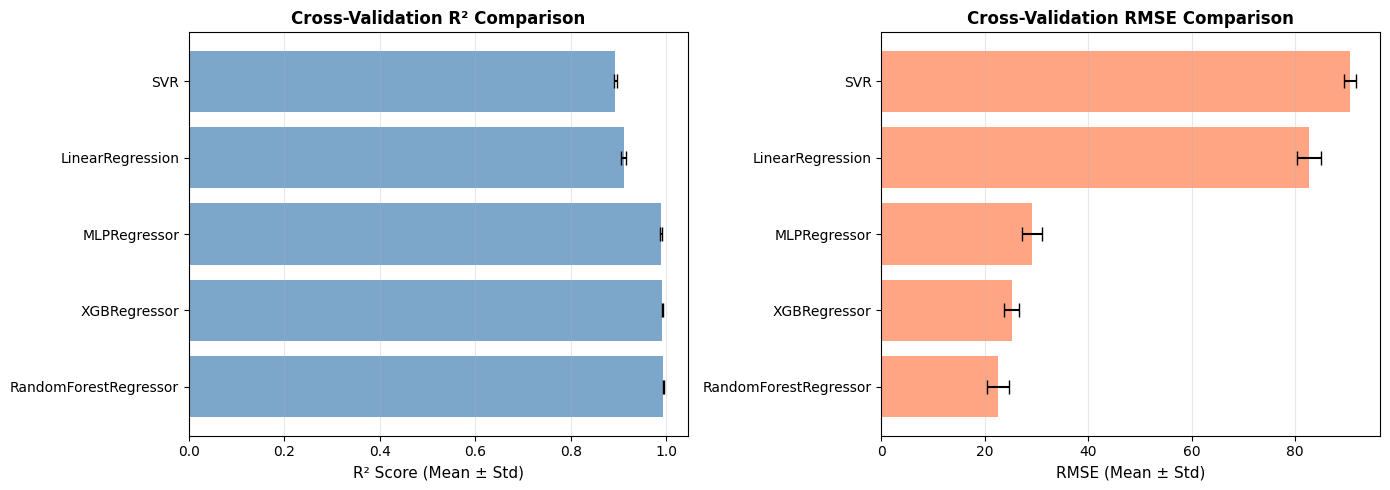

In [13]:
# K-Fold Cross-Validation
print("="*80)
print("K-FOLD CROSS-VALIDATION ANALYSIS")
print("="*80)

# Define cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for each model
cv_results = []

for model_name, model in models.items():
    print(f"\nPerforming 5-fold CV for {model_name}...")
    
    # Negative MSE is used in cross_val_score for regression
    cv_scores = cross_val_score(model, X_train_processed, y_train, 
                                 cv=kfold, scoring='r2', n_jobs=-1)
    cv_rmse_scores = cross_val_score(model, X_train_processed, y_train,
                                      cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse_scores = np.sqrt(-cv_rmse_scores)
    
    cv_results.append({
        'Model': model_name,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std(),
        'CV_RMSE_Mean': cv_rmse_scores.mean(),
        'CV_RMSE_Std': cv_rmse_scores.std(),
        'CV_R2_Min': cv_scores.min(),
        'CV_R2_Max': cv_scores.max()
    })
    
    print(f"  R² CV: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  RMSE CV: {cv_rmse_scores.mean():.2f} (+/- {cv_rmse_scores.std():.2f})")

cv_df = pd.DataFrame(cv_results).sort_values('CV_R2_Mean', ascending=False)

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*80)
print(cv_df.to_string(index=False))

# Visualize CV results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison with error bars
axes[0].barh(cv_df['Model'], cv_df['CV_R2_Mean'], 
             xerr=cv_df['CV_R2_Std'], color='steelblue', alpha=0.7, capsize=5)
axes[0].set_xlabel('R² Score (Mean ± Std)', fontsize=11)
axes[0].set_title('Cross-Validation R² Comparison', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')

# RMSE comparison with error bars
axes[1].barh(cv_df['Model'], cv_df['CV_RMSE_Mean'],
             xerr=cv_df['CV_RMSE_Std'], color='coral', alpha=0.7, capsize=5)
axes[1].set_xlabel('RMSE (Mean ± Std)', fontsize=11)
axes[1].set_title('Cross-Validation RMSE Comparison', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

In [14]:
# Display model structure and details
print("="*80)
print("MODEL STRUCTURE AND CONFIGURATION DETAILS")
print("="*80)

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Model: {model_name}")
    print(f"{'='*80}")
    
    # Model class and type
    print(f"\nModel Type: {type(model).__name__}")
    print(f"Module: {type(model).__module__}")
    
    # Get all parameters
    print(f"\nModel Parameters:")
    print("-" * 80)
    params = model.get_params()
    
    # Sort parameters for better readability
    for param_name in sorted(params.keys()):
        param_value = params[param_name]
        
        # Format the value based on type
        if isinstance(param_value, (int, float, bool, str)) or param_value is None:
            print(f"  {param_name:30s}: {param_value}")
        elif callable(param_value):
            print(f"  {param_name:30s}: {param_value.__name__}")
        else:
            print(f"  {param_name:30s}: {type(param_value).__name__}")
    
    # Additional model-specific information
    print(f"\n{'Model-Specific Information':^80}")
    print("-" * 80)
    
    if model_name == 'LinearRegression':
        print("  • Simple linear model: y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ")
        print("  • No hyperparameters to tune")
        print("  • Fast training and prediction")
        print("  • Assumes linear relationship between features and target")
    
    elif model_name == 'SVR':
        print(f"  • Support Vector Regression with {model.kernel} kernel")
        print(f"  • Epsilon-insensitive loss (ε = {model.epsilon})")
        print(f"  • Regularization parameter C = {model.C}")
        print("  • Can model non-linear relationships")
        print("  • Memory-intensive for large datasets")
    
    elif model_name == 'RandomForestRegressor':
        print(f"  • Ensemble of {model.n_estimators} decision trees")
        print(f"  • Maximum depth: {model.max_depth if model.max_depth else 'Unlimited'}")
        print(f"  • Minimum samples to split: {model.min_samples_split}")
        print(f"  • Minimum samples per leaf: {model.min_samples_leaf}")
        print(f"  • Bootstrap sampling: {model.bootstrap}")
        print("  • Handles non-linear relationships well")
        print("  • Provides feature importance")
        print("  • Resistant to overfitting")
        if hasattr(model, 'n_features_in_'):
            print(f"  • Number of features used: {model.n_features_in_}")
        if hasattr(model, 'n_outputs_'):
            print(f"  • Number of outputs: {model.n_outputs_}")
    
    elif model_name == 'XGBRegressor':
        print(f"  • Gradient boosting with {model.n_estimators} trees")
        print(f"  • Learning rate: {model.learning_rate}")
        print(f"  • Maximum depth: {model.max_depth}")
        print(f"  • Subsample ratio: {model.subsample}")
        print(f"  • Column subsample: {model.colsample_bytree}")
        print("  • Sequential ensemble learning")
        print("  • Optimizes gradient descent")
        print("  • Generally high performance")
        if hasattr(model, 'n_features_in_'):
            print(f"  • Number of features used: {model.n_features_in_}")
    
    elif model_name == 'MLPRegressor':
        print(f"  • Neural network architecture: {model.hidden_layer_sizes}")
        print(f"  • Activation function: {model.activation}")
        print(f"  • Solver/Optimizer: {model.solver}")
        print(f"  • Learning rate: {model.learning_rate}")
        if model.learning_rate == 'constant':
            print(f"  • Initial learning rate: {model.learning_rate_init}")
        print(f"  • Maximum iterations: {model.max_iter}")
        print(f"  • Alpha (L2 penalty): {model.alpha}")
        print(f"  • Batch size: {model.batch_size}")
        print("  • Can learn complex non-linear patterns")
        print("  • Requires careful tuning")
        if hasattr(model, 'n_features_in_'):
            print(f"  • Number of features used: {model.n_features_in_}")
        if hasattr(model, 'n_iter_'):
            print(f"  • Actual iterations completed: {model.n_iter_}")
        if hasattr(model, 'n_layers_'):
            print(f"  • Total number of layers: {model.n_layers_}")
        if hasattr(model, 'out_activation_'):
            print(f"  • Output activation: {model.out_activation_}")

print("\n" + "="*80)
print("END OF MODEL DETAILS")
print("="*80)

MODEL STRUCTURE AND CONFIGURATION DETAILS

Model: LinearRegression

Model Type: LinearRegression
Module: sklearn.linear_model._base

Model Parameters:
--------------------------------------------------------------------------------
  copy_X                        : True
  fit_intercept                 : True
  n_jobs                        : None
  positive                      : False
  tol                           : 1e-06

                           Model-Specific Information                           
--------------------------------------------------------------------------------
  • Simple linear model: y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ
  • No hyperparameters to tune
  • Fast training and prediction
  • Assumes linear relationship between features and target

Model: SVR

Model Type: SVR
Module: sklearn.svm._classes

Model Parameters:
--------------------------------------------------------------------------------
  C                             : 1.0
  cache_size                 

### Statistical Significance Testing

In [15]:
# Statistical Comparison of Models
print("="*80)
print("STATISTICAL SIGNIFICANCE TESTING - MODEL COMPARISON")
print("="*80)

# Get predictions from all models
all_predictions_test = {}
for model_name, model in models.items():
    all_predictions_test[model_name] = model.predict(X_test_processed)

# Pairwise comparison of top models
best_models = list(results_df.nlargest(3, 'R2')['Model'])
print(f"\nComparing top 3 models: {', '.join(best_models)}")

comparison_results = []

for i in range(len(best_models)):
    for j in range(i+1, len(best_models)):
        model1 = best_models[i]
        model2 = best_models[j]
        
        # Calculate squared errors
        errors1 = (y_test - all_predictions_test[model1]) ** 2
        errors2 = (y_test - all_predictions_test[model2]) ** 2
        
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(errors1, errors2)
        
        # Effect size (Cohen's d)
        mean_diff = np.mean(errors1 - errors2)
        pooled_std = np.sqrt((np.var(errors1) + np.var(errors2)) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        # Determine winner
        if p_value < 0.05:
            if mean_diff > 0:
                winner = model2
                significance = "Significant"
            else:
                winner = model1
                significance = "Significant"
        else:
            winner = "No difference"
            significance = "Not significant"
        
        comparison_results.append({
            'Model_1': model1,
            'Model_2': model2,
            't_statistic': f"{t_stat:.4f}",
            'p_value': f"{p_value:.4e}",
            "Cohen's_d": f"{abs(cohens_d):.4f}",
            'Significance': significance,
            'Better_Model': winner
        })
        
        print(f"\n{model1} vs {model2}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4e}")
        print(f"  Cohen's d: {abs(cohens_d):.4f}")
        print(f"  Result: {significance} - {winner}")

comparison_df = pd.DataFrame(comparison_results)
print("\n" + "="*80)
print("PAIRWISE COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)

STATISTICAL SIGNIFICANCE TESTING - MODEL COMPARISON

Comparing top 3 models: XGBRegressor, RandomForestRegressor, SVR

XGBRegressor vs RandomForestRegressor:
  t-statistic: -6.1392
  p-value: 8.8265e-10
  Cohen's d: 0.0235
  Result: Significant - XGBRegressor

XGBRegressor vs SVR:
  t-statistic: -3.6842
  p-value: 2.3147e-04
  Cohen's d: 0.0379
  Result: Significant - XGBRegressor

RandomForestRegressor vs SVR:
  t-statistic: -1.2958
  p-value: 1.9509e-01
  Cohen's d: 0.0130
  Result: Not significant - No difference

PAIRWISE COMPARISON SUMMARY
              Model_1               Model_2 t_statistic    p_value Cohen's_d    Significance  Better_Model
         XGBRegressor RandomForestRegressor     -6.1392 8.8265e-10    0.0235     Significant  XGBRegressor
         XGBRegressor                   SVR     -3.6842 2.3147e-04    0.0379     Significant  XGBRegressor
RandomForestRegressor                   SVR     -1.2958 1.9509e-01    0.0130 Not significant No difference


Comparing top 3 mod


=== LinearRegression - Prediction Bias Analysis ===
Mean Error (Actual - Predicted): -11.9096
Median Error: 8.7160
Bias: Model tends to OVERPREDICT (predicts higher than actual)
Underprediction instances: 57.08%
Overprediction instances: 42.92%

=== SVR - Prediction Bias Analysis ===
Mean Error (Actual - Predicted): -15.0373
Median Error: 5.4327
Bias: Model tends to OVERPREDICT (predicts higher than actual)
Underprediction instances: 55.27%
Overprediction instances: 44.73%

=== RandomForestRegressor - Prediction Bias Analysis ===
Mean Error (Actual - Predicted): -18.0331
Median Error: -2.0850
Bias: Model tends to OVERPREDICT (predicts higher than actual)
Underprediction instances: 45.23%
Overprediction instances: 54.53%

=== XGBRegressor - Prediction Bias Analysis ===
Mean Error (Actual - Predicted): -14.3976
Median Error: 1.1798
Bias: Model tends to OVERPREDICT (predicts higher than actual)
Underprediction instances: 51.87%
Overprediction instances: 48.13%

=== MLPRegressor - Predict

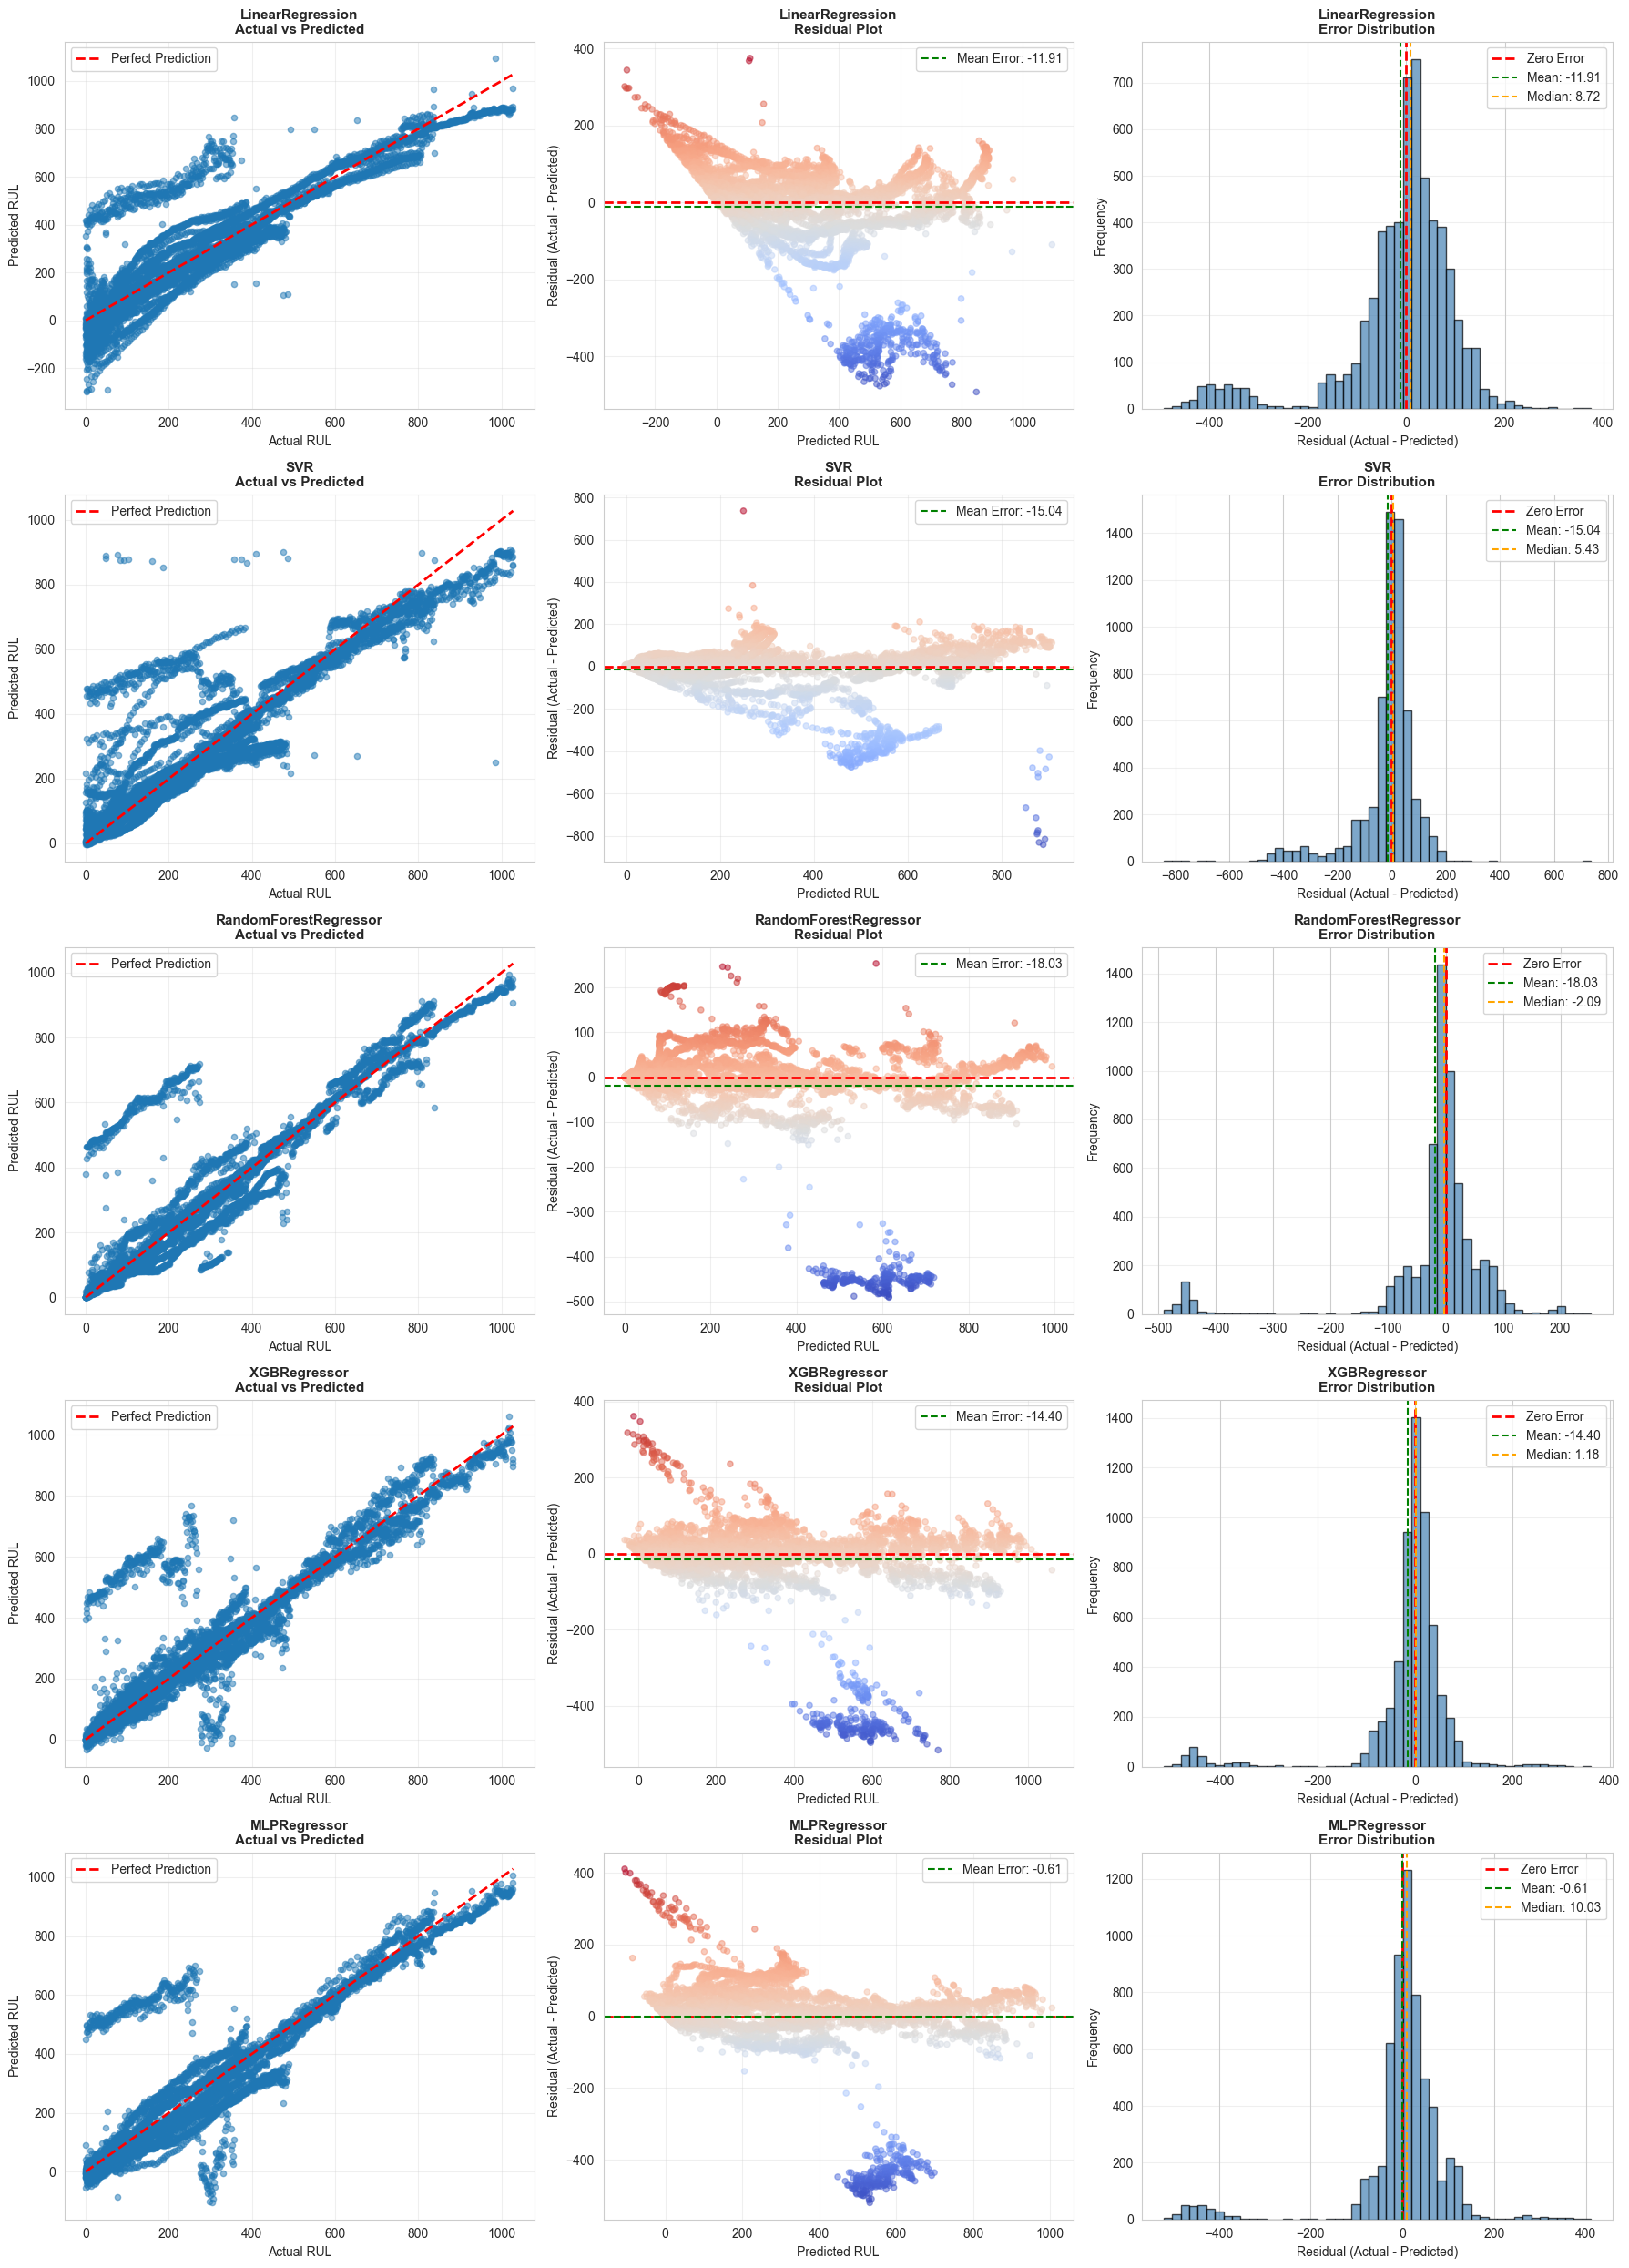


SUMMARY: Prediction Bias Comparison Across Models
                Model  Mean_Error  Std_Error Bias_Direction  Underpredict_%  Overpredict_%
     LinearRegression  -11.909629 115.909816    Overpredict       57.078313      42.921687
                  SVR  -15.037279 108.703086    Overpredict       55.271084      44.728916
RandomForestRegressor  -18.033146 105.761393    Overpredict       45.230924      54.534806
         XGBRegressor  -14.397572 101.675559    Overpredict       51.874163      48.125837
         MLPRegressor   -0.610546 109.780981    Overpredict       61.395582      38.604418

Note: Positive Mean_Error indicates underprediction, Negative indicates overprediction


In [16]:
# Analyze prediction patterns and error distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")

# Create figure with subplots for each model
n_models = len(models)
fig, axes = plt.subplots(n_models, 3, figsize=(18, 5 * n_models))

# If only one model, make axes 2D
if n_models == 1:
    axes = axes.reshape(1, -1)

# Store all predictions for comparison
all_predictions = {}

for idx, (model_name, model) in enumerate(models.items()):
    # Get predictions
    y_pred = model.predict(X_test_processed)
    all_predictions[model_name] = y_pred
    
    # Calculate residuals (errors)
    residuals = y_test - y_pred
    
    # Calculate metrics for bias analysis
    mean_error = np.mean(residuals)
    median_error = np.median(residuals)
    underprediction_pct = (residuals > 0).sum() / len(residuals) * 100
    overprediction_pct = (residuals < 0).sum() / len(residuals) * 100
    
    print(f"\n=== {model_name} - Prediction Bias Analysis ===")
    print(f"Mean Error (Actual - Predicted): {mean_error:.4f}")
    print(f"Median Error: {median_error:.4f}")
    if mean_error > 0:
        print(f"Bias: Model tends to UNDERPREDICT (predicts lower than actual)")
    elif mean_error < 0:
        print(f"Bias: Model tends to OVERPREDICT (predicts higher than actual)")
    else:
        print(f"Bias: Model is unbiased")
    print(f"Underprediction instances: {underprediction_pct:.2f}%")
    print(f"Overprediction instances: {overprediction_pct:.2f}%")
    
    # Plot 1: Actual vs Predicted
    axes[idx, 0].scatter(y_test, y_pred, alpha=0.5, s=20)
    axes[idx, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                      'r--', lw=2, label='Perfect Prediction')
    axes[idx, 0].set_xlabel('Actual RUL', fontsize=10)
    axes[idx, 0].set_ylabel('Predicted RUL', fontsize=10)
    axes[idx, 0].set_title(f'{model_name}\nActual vs Predicted', fontsize=11, fontweight='bold')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Residual Plot
    axes[idx, 1].scatter(y_pred, residuals, alpha=0.5, s=20, c=residuals, cmap='coolwarm')
    axes[idx, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx, 1].axhline(y=mean_error, color='green', linestyle='--', lw=1.5, 
                         label=f'Mean Error: {mean_error:.2f}')
    axes[idx, 1].set_xlabel('Predicted RUL', fontsize=10)
    axes[idx, 1].set_ylabel('Residual (Actual - Predicted)', fontsize=10)
    axes[idx, 1].set_title(f'{model_name}\nResidual Plot', fontsize=11, fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Plot 3: Error Distribution
    axes[idx, 2].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx, 2].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
    axes[idx, 2].axvline(x=mean_error, color='green', linestyle='--', lw=1.5, 
                         label=f'Mean: {mean_error:.2f}')
    axes[idx, 2].axvline(x=median_error, color='orange', linestyle='--', lw=1.5, 
                         label=f'Median: {median_error:.2f}')
    axes[idx, 2].set_xlabel('Residual (Actual - Predicted)', fontsize=10)
    axes[idx, 2].set_ylabel('Frequency', fontsize=10)
    axes[idx, 2].set_title(f'{model_name}\nError Distribution', fontsize=11, fontweight='bold')
    axes[idx, 2].legend()
    axes[idx, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics for all models
print("\n" + "="*80)
print("SUMMARY: Prediction Bias Comparison Across Models")
print("="*80)

bias_summary = []
for model_name, y_pred in all_predictions.items():
    residuals = y_test - y_pred
    mean_error = np.mean(residuals)
    std_error = np.std(residuals)
    bias_direction = "Underpredict" if mean_error > 0 else "Overpredict" if mean_error < 0 else "Unbiased"
    
    bias_summary.append({
        'Model': model_name,
        'Mean_Error': mean_error,
        'Std_Error': std_error,
        'Bias_Direction': bias_direction,
        'Underpredict_%': (residuals > 0).sum() / len(residuals) * 100,
        'Overpredict_%': (residuals < 0).sum() / len(residuals) * 100
    })

bias_df = pd.DataFrame(bias_summary)
print(bias_df.to_string(index=False))
print("\nNote: Positive Mean_Error indicates underprediction, Negative indicates overprediction")

### Hyperparameter Tuning

In [17]:
# Hyperparameter Tuning for Best Models
print("="*80)
print("HYPERPARAMETER TUNING - RandomizedSearchCV")
print("="*80)

# Define parameter grids for top models
param_grids = {
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 15, 20, 25, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
}

tuning_results = []

# Tune each model
for model_name in ['RandomForestRegressor', 'XGBRegressor']:
    if model_name not in models:
        continue
    
    print(f"\n--- Tuning {model_name} ---")
    
    # Get base model
    base_model = models[model_name]
    
    # Randomized search
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_grids[model_name],
        n_iter=20,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    print("  Running RandomizedSearchCV...")
    random_search.fit(X_train_processed, y_train)
    
    print(f"  Best parameters: {random_search.best_params_}")
    print(f"  Best CV R²: {random_search.best_score_:.4f}")
    
    # Evaluate on test set
    y_pred_tuned = random_search.predict(X_test_processed)
    r2_tuned = r2_score(y_test, y_pred_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
    
    print(f"  Test R²: {r2_tuned:.4f}")
    print(f"  Test RMSE: {rmse_tuned:.2f}")
    print(f"  Test MAE: {mae_tuned:.2f}")
    
    # Get baseline performance
    baseline_result = results_df[results_df['Model'] == model_name]
    if len(baseline_result) > 0:
        baseline_r2 = baseline_result['R2'].values[0]
        improvement = ((r2_tuned - baseline_r2) / abs(baseline_r2)) * 100
        print(f"  Improvement over baseline: {improvement:.2f}%")
    
    tuning_results.append({
        'Model': model_name,
        'Best_CV_R2': random_search.best_score_,
        'Test_R2': r2_tuned,
        'Test_RMSE': rmse_tuned,
        'Test_MAE': mae_tuned,
        'Best_Params': str(random_search.best_params_)
    })

tuning_df = pd.DataFrame(tuning_results)
print("\n" + "="*80)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*80)
print(tuning_df.to_string(index=False))

print("\n" + "="*80)

HYPERPARAMETER TUNING - RandomizedSearchCV

--- Tuning RandomForestRegressor ---
  Running RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}
  Best CV R²: 0.5006
  Test R²: 0.8320
  Test RMSE: 100.42
  Test MAE: 45.95
  Improvement over baseline: 2.94%

--- Tuning XGBRegressor ---
  Running RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}
  Best CV R²: 0.5006
  Test R²: 0.8320
  Test RMSE: 100.42
  Test MAE: 45.95
  Improvement over baseline: 2.94%

--- Tuning XGBRegressor ---
  Running RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  Best parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'co

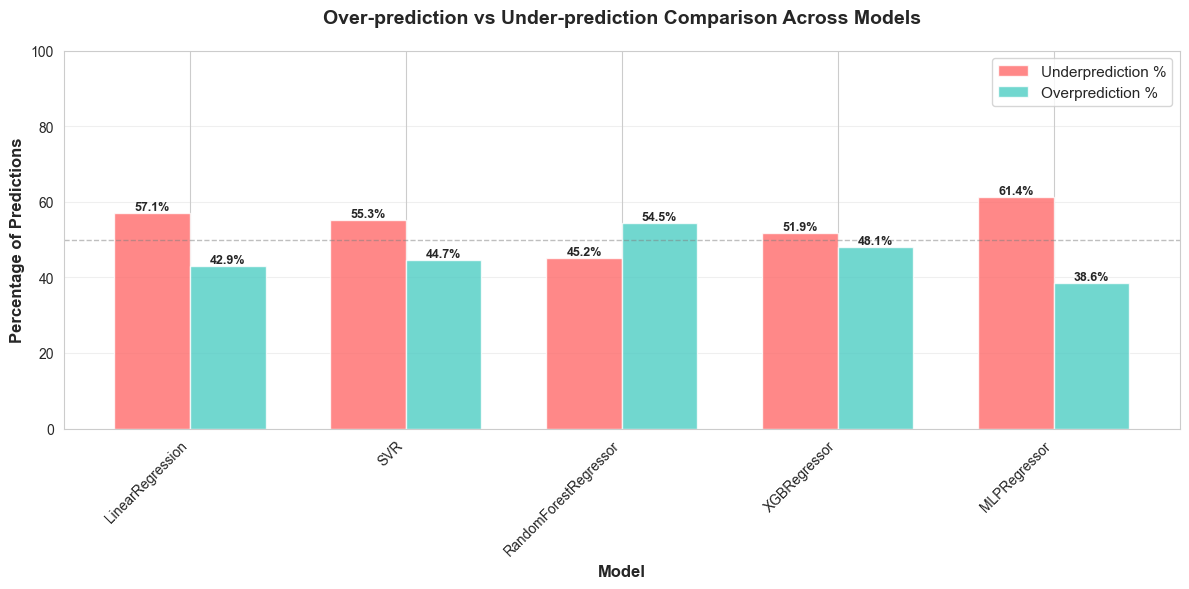


INTERPRETATION GUIDE:
• Underprediction % (Red): Model predicts LOWER than actual RUL
  → Conservative estimates (may lead to premature maintenance)

• Overprediction % (Teal): Model predicts HIGHER than actual RUL
  → Optimistic estimates (may lead to unexpected failures)

• Ideal: Balanced distribution around 50% each with low mean error


In [18]:
# Bar chart comparing over/underprediction across models
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(bias_df))
width = 0.35

# Create bars for underprediction and overprediction percentages
bars1 = ax.bar(x - width/2, bias_df['Underpredict_%'], width, 
               label='Underprediction %', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x + width/2, bias_df['Overpredict_%'], width, 
               label='Overprediction %', color='#4ECDC4', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Customize the plot
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Predictions', fontsize=12, fontweight='bold')
ax.set_title('Over-prediction vs Under-prediction Comparison Across Models', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(bias_df['Model'], rotation=45, ha='right')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)

# Add a horizontal line at 50% for reference
ax.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% reference')

plt.tight_layout()
plt.show()

# Print interpretation
print("\n" + "="*80)
print("INTERPRETATION GUIDE:")
print("="*80)
print("• Underprediction % (Red): Model predicts LOWER than actual RUL")
print("  → Conservative estimates (may lead to premature maintenance)")
print("\n• Overprediction % (Teal): Model predicts HIGHER than actual RUL")
print("  → Optimistic estimates (may lead to unexpected failures)")
print("\n• Ideal: Balanced distribution around 50% each with low mean error")
print("="*80)

In [19]:
# Task 2: Feature Ablation Study (Using Random Forest) - IMPROVED
print("\n=== Feature Ablation Study ===")

# Define feature groups with error handling
available_columns = set(X_train.columns)

# Check which rolling features are available
rolling_features = [col for col in X_train.columns if 'rolling_' in col]
print(f"Found {len(rolling_features)} rolling features")

feature_groups = {
    'Capacity_Only': ['soh_percent', 'discharge_capacity_ah_max'],
    'Capacity_Voltage': ['soh_percent', 'discharge_capacity_ah_max', 'voltage_v_std', 'voltage_v_mean'],
    'Capacity_Temp': ['soh_percent', 'discharge_capacity_ah_max', 'aux_temperature_1_c_mean', 'aux_temperature_1_c_std'],
    'Capacity_Rolling': ['soh_percent', 'discharge_capacity_ah_max'] + rolling_features,
    'All_Features': list(X_train.columns)
}

# Store ablation results and models
ablation_results = []
trained_models = {}

# Iterate through each feature group
for group_name, features in feature_groups.items():
    # Filter out features that don't exist
    valid_features = [f for f in features if f in available_columns]
    
    if len(valid_features) == 0:
        print(f"\nSkipping {group_name}: No valid features found")
        continue
    
    missing_features = set(features) - set(valid_features)
    if missing_features:
        print(f"\nWarning: {group_name} missing features: {missing_features}")
    
    print(f"\nEvaluating feature group: {group_name} ({len(valid_features)} features)")
    
    # Create subset of features
    X_train_subset = X_train[valid_features]
    X_test_subset = X_test[valid_features]
    
    # Identify numeric and categorical features in this subset
    numeric_features_subset = X_train_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical_features_subset = X_train_subset.select_dtypes(include=['object', 'category']).columns
    
    # Create new preprocessor for this subset
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    transformers = []
    if len(numeric_features_subset) > 0:
        transformers.append(('num', numeric_transformer, numeric_features_subset))
    if len(categorical_features_subset) > 0:
        transformers.append(('cat', categorical_transformer, categorical_features_subset))
    
    preprocessor_subset = ColumnTransformer(transformers=transformers)
    
    # Fit and transform the data
    X_train_processed_subset = preprocessor_subset.fit_transform(X_train_subset)
    X_test_processed_subset = preprocessor_subset.transform(X_test_subset)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_processed_subset, y_train)
    
    # Store the model
    trained_models[group_name] = rf_model
    
    # Make predictions
    y_pred = rf_model.predict(X_test_processed_subset)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store results
    ablation_results.append({
        'Feature_Group': group_name,
        'Num_Features': len(valid_features),
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    })
    
    print(f"{group_name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Create and display ablation results DataFrame
ablation_df = pd.DataFrame(ablation_results)

# Sort by R2 score (descending)
ablation_df = ablation_df.sort_values('R2', ascending=False).reset_index(drop=True)

# Add improvement over baseline (Capacity_Only)
if 'Capacity_Only' in ablation_df['Feature_Group'].values:
    baseline_r2 = ablation_df[ablation_df['Feature_Group'] == 'Capacity_Only']['R2'].values[0]
    baseline_rmse = ablation_df[ablation_df['Feature_Group'] == 'Capacity_Only']['RMSE'].values[0]
    ablation_df['R2_Improvement_%'] = ((ablation_df['R2'] - baseline_r2) / abs(baseline_r2)) * 100
    ablation_df['RMSE_Reduction_%'] = ((baseline_rmse - ablation_df['RMSE']) / baseline_rmse) * 100

print("\n=== Feature Ablation Results (Sorted by R2) ===")
print(ablation_df.to_string(index=False))

# Identify best performing feature group
best_group = ablation_df.iloc[0]['Feature_Group']
print(f"\n✓ Best performing feature group: {best_group}")


=== Feature Ablation Study ===
Found 18 rolling features

Evaluating feature group: Capacity_Only (2 features)
Capacity_Only - R2: -0.1412, RMSE: 261.7402, MAE: 195.3272

Evaluating feature group: Capacity_Voltage (4 features)
Capacity_Only - R2: -0.1412, RMSE: 261.7402, MAE: 195.3272

Evaluating feature group: Capacity_Voltage (4 features)
Capacity_Voltage - R2: 0.7182, RMSE: 130.0780, MAE: 68.5971

Evaluating feature group: Capacity_Temp (4 features)
Capacity_Voltage - R2: 0.7182, RMSE: 130.0780, MAE: 68.5971

Evaluating feature group: Capacity_Temp (4 features)
Capacity_Temp - R2: 0.3919, RMSE: 191.0598, MAE: 127.8518

Evaluating feature group: Capacity_Rolling (20 features)
Capacity_Temp - R2: 0.3919, RMSE: 191.0598, MAE: 127.8518

Evaluating feature group: Capacity_Rolling (20 features)
Capacity_Rolling - R2: 0.7992, RMSE: 109.7892, MAE: 54.8166

Evaluating feature group: All_Features (39 features)
Capacity_Rolling - R2: 0.7992, RMSE: 109.7892, MAE: 54.8166

Evaluating feature gr

### Learning Curves Analysis

LEARNING CURVES ANALYSIS

Generating learning curve for XGBRegressor...
  ⚠ Potential overfitting detected (gap: 0.4919)

Generating learning curve for RandomForestRegressor...
  ⚠ Potential overfitting detected (gap: 0.4919)

Generating learning curve for RandomForestRegressor...
  ⚠ Potential overfitting detected (gap: 0.5326)
  ⚠ Potential overfitting detected (gap: 0.5326)


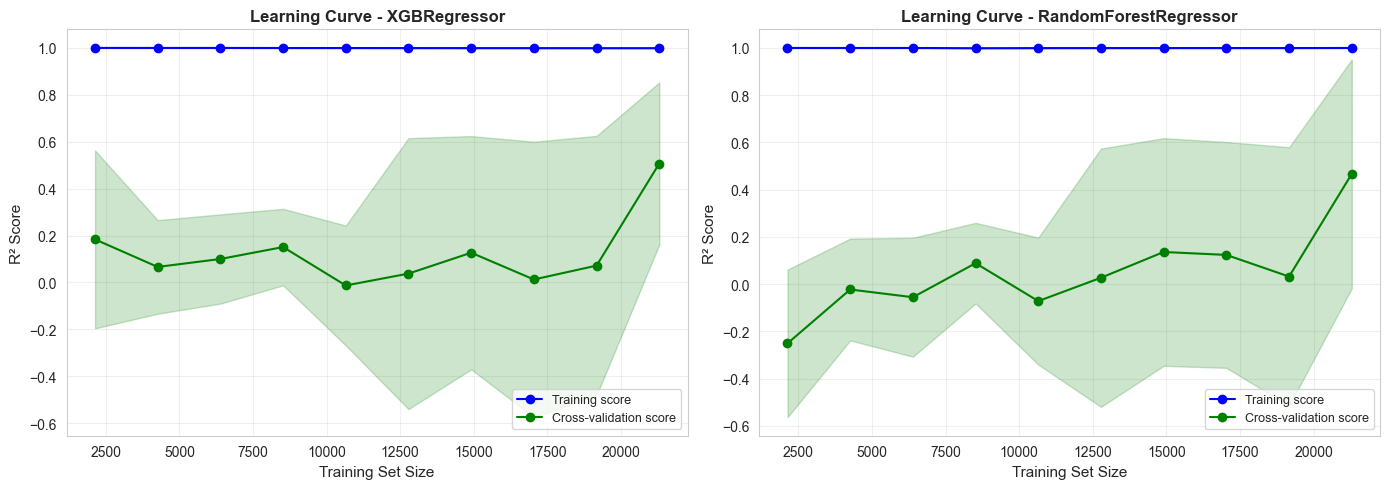

In [20]:
# Learning Curves for Top Models
print("="*80)
print("LEARNING CURVES ANALYSIS")
print("="*80)

# Select top 2 models for learning curve analysis
top_2_models = list(results_df.nlargest(2, 'R2')['Model'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, model_name in enumerate(top_2_models):
    print(f"\nGenerating learning curve for {model_name}...")
    
    model = models[model_name]
    
    # Generate learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_processed, y_train,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )
    
    # Calculate mean and std
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    # Plot
    axes[idx].plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                            alpha=0.2, color='blue')
    
    axes[idx].plot(train_sizes, val_mean, 'o-', color='green', label='Cross-validation score')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                            alpha=0.2, color='green')
    
    axes[idx].set_xlabel('Training Set Size', fontsize=11)
    axes[idx].set_ylabel('R² Score', fontsize=11)
    axes[idx].set_title(f'Learning Curve - {model_name}', fontsize=12, fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=9)
    axes[idx].grid(alpha=0.3)
    
    # Check for overfitting
    final_gap = train_mean[-1] - val_mean[-1]
    if final_gap > 0.1:
        print(f"  ⚠ Potential overfitting detected (gap: {final_gap:.4f})")
    elif final_gap < 0.05:
        print(f"  ✓ Good generalization (gap: {final_gap:.4f})")
    else:
        print(f"  ⓘ Moderate fit (gap: {final_gap:.4f})")

plt.tight_layout()
plt.show()

print("\n" + "="*80)

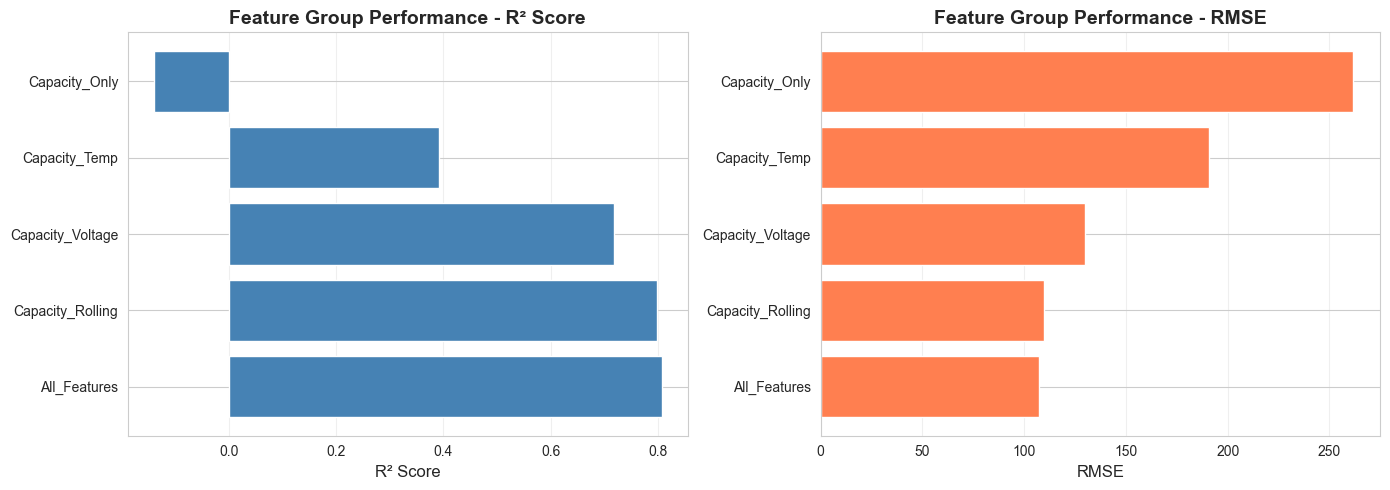


Best feature group 'All_Features' achieved R² = 0.8083


In [21]:
# Visualize Feature Ablation Results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot R2 scores
axes[0].barh(ablation_df['Feature_Group'], ablation_df['R2'], color='steelblue')
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Feature Group Performance - R² Score', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Plot RMSE
axes[1].barh(ablation_df['Feature_Group'], ablation_df['RMSE'], color='coral')
axes[1].set_xlabel('RMSE', fontsize=12)
axes[1].set_title('Feature Group Performance - RMSE', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest feature group '{best_group}' achieved R² = {ablation_df.iloc[0]['R2']:.4f}")


=== Feature Importance for 'All_Features' Model ===
Total features after preprocessing: 54
Feature names extracted: 54


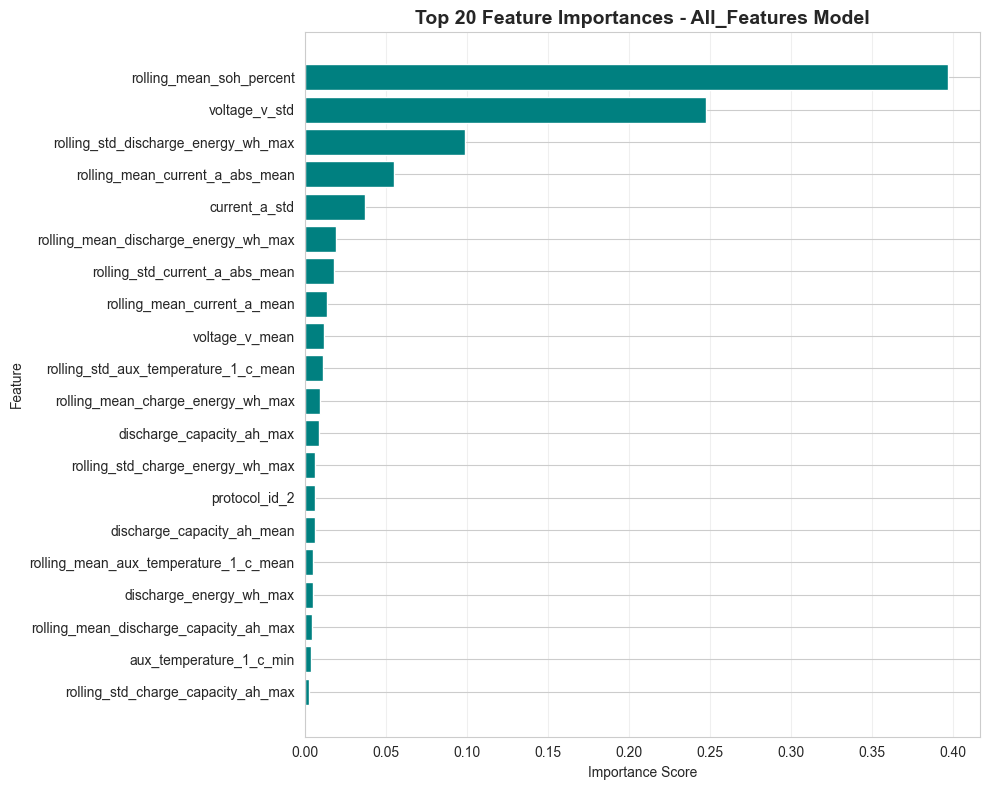


Top 10 features by importance:
1. rolling_mean_soh_percent: 0.3969
2. voltage_v_std: 0.2476
3. rolling_std_discharge_energy_wh_max: 0.0991
4. rolling_mean_current_a_abs_mean: 0.0555
5. current_a_std: 0.0373
6. rolling_mean_discharge_energy_wh_max: 0.0195
7. rolling_std_current_a_abs_mean: 0.0183
8. rolling_mean_current_a_mean: 0.0137
9. voltage_v_mean: 0.0117
10. rolling_std_aux_temperature_1_c_mean: 0.0112


In [22]:
# Feature Importance Analysis for Best Model
if best_group in trained_models:
    best_model = trained_models[best_group]
    
    # Get feature names after preprocessing
    feature_group_features = feature_groups[best_group]
    valid_features = [f for f in feature_group_features if f in available_columns]
    
    # Recreate the subset for this feature group
    X_train_subset = X_train[valid_features]
    
    # Identify numeric and categorical features in this subset
    numeric_features_subset = X_train_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical_features_subset = X_train_subset.select_dtypes(include=['object', 'category']).columns
    
    # Create preprocessor to get feature names
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    transformers = []
    if len(numeric_features_subset) > 0:
        transformers.append(('num', numeric_transformer, numeric_features_subset))
    if len(categorical_features_subset) > 0:
        transformers.append(('cat', categorical_transformer, categorical_features_subset))
    
    preprocessor_subset = ColumnTransformer(transformers=transformers)
    preprocessor_subset.fit(X_train_subset)
    
    # Get feature names after preprocessing
    feature_names = []
    
    # Add numeric feature names
    if len(numeric_features_subset) > 0:
        feature_names.extend(numeric_features_subset.tolist())
    
    # Add categorical feature names (one-hot encoded)
    if len(categorical_features_subset) > 0:
        cat_encoder = preprocessor_subset.named_transformers_['cat'].named_steps['onehot']
        for i, cat_feature in enumerate(categorical_features_subset):
            cat_categories = cat_encoder.categories_[i]
            feature_names.extend([f"{cat_feature}_{cat}" for cat in cat_categories])
    
    # Get feature importance
    importances = best_model.feature_importances_
    
    print(f"\n=== Feature Importance for '{best_group}' Model ===")
    print(f"Total features after preprocessing: {len(importances)}")
    print(f"Feature names extracted: {len(feature_names)}")
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure same length
        'Importance': importances
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    # Plot top features
    n_top = min(20, len(importance_df))
    top_features = importance_df.head(n_top)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(n_top), top_features['Importance'].values, color='teal')
    plt.yticks(range(n_top), top_features['Feature'].values)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Top {n_top} Feature Importances - {best_group} Model', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 10 features by importance:")
    for i, row in enumerate(importance_df.head(10).itertuples(), 1):
        print(f"{i}. {row.Feature}: {row.Importance:.4f}")


### Model Explainability - SHAP and Partial Dependence

PARTIAL DEPENDENCE ANALYSIS

Generating Partial Dependence Plots for top 5 features...

Generating Partial Dependence Plots for top 5 features...


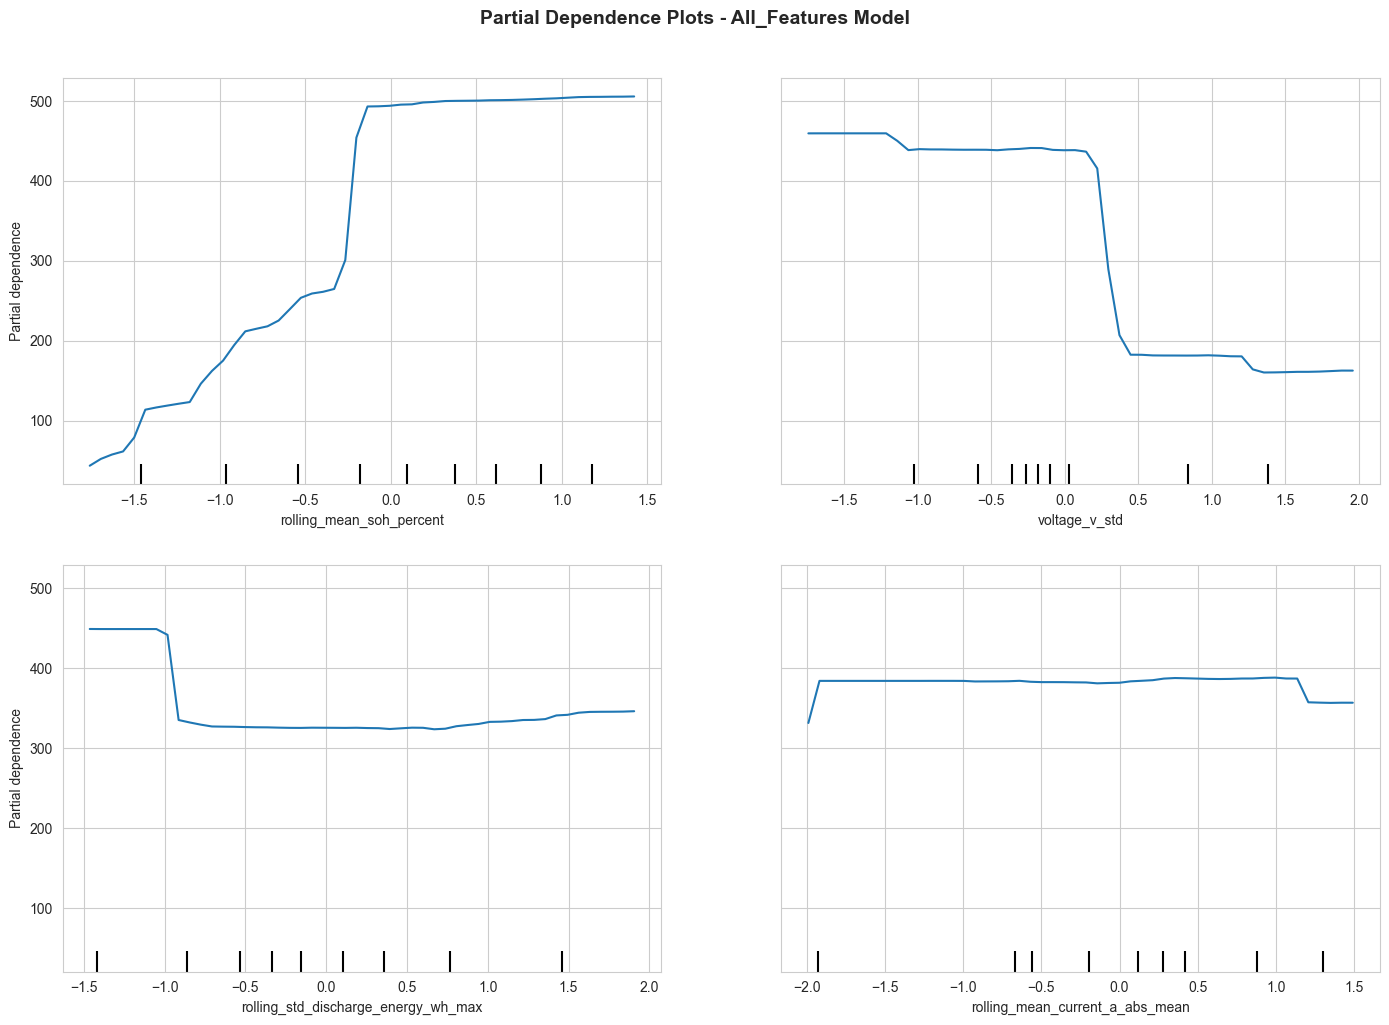

✓ Partial Dependence Plots generated successfully



In [23]:
# Partial Dependence Plots for Top Features
print("="*80)
print("PARTIAL DEPENDENCE ANALYSIS")
print("="*80)

if best_group in trained_models:
    best_model_ablation = trained_models[best_group]
    
    # Get top features
    if hasattr(best_model_ablation, 'feature_importances_'):
        feature_importance_indices = np.argsort(best_model_ablation.feature_importances_)[-5:][::-1]
        
        print("\nGenerating Partial Dependence Plots for top 5 features...")
        
        # Create partial dependence display
        try:
            fig, ax = plt.subplots(figsize=(14, 10))
            
            # Get the feature subset used
            feature_group_features = feature_groups[best_group]
            valid_features = [f for f in feature_group_features if f in available_columns]
            X_train_subset = X_train[valid_features]
            
            # Identify numeric features
            numeric_features_subset = X_train_subset.select_dtypes(include=['int64', 'float64']).columns
            
            # Create preprocessor for numeric only
            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ])
            
            preprocessor_pd = ColumnTransformer(
                transformers=[('num', numeric_transformer, numeric_features_subset)]
            )
            
            X_train_processed_pd = preprocessor_pd.fit_transform(X_train_subset)
            
            # Select top numeric features only
            top_features_idx = [i for i in feature_importance_indices if i < len(numeric_features_subset)][:4]
            
            if len(top_features_idx) > 0:
                display = PartialDependenceDisplay.from_estimator(
                    best_model_ablation,
                    X_train_processed_pd,
                    features=top_features_idx,
                    feature_names=list(numeric_features_subset),
                    n_cols=2,
                    grid_resolution=50,
                    ax=ax
                )
                
                plt.suptitle(f'Partial Dependence Plots - {best_group} Model', 
                            fontsize=14, fontweight='bold', y=1.02)
                plt.tight_layout()
                plt.show()
                
                print("✓ Partial Dependence Plots generated successfully")
            else:
                print("⚠ Not enough numeric features for PD plots")
                
        except Exception as e:
            print(f"⚠ Could not generate PD plots: {str(e)}")
    else:
        print("⚠ Model does not support feature importances")
else:
    print("⚠ Best model not available for PD analysis")

print("\n" + "="*80)

### RUL Segment Analysis

PERFORMANCE ANALYSIS BY RUL SEGMENTS

Performance by RUL Segment:
                Model         Segment  N_Samples          R2       RMSE       MAE
         XGBRegressor Critical (0-20)        340 -350.743134 108.145545 34.309902
         XGBRegressor Warning (20-50)        508 -165.403244 111.294123 39.732658
         XGBRegressor Normal (50-100)        706  -76.363571 124.792269 49.639053
         XGBRegressor  Healthy (100+)       4421    0.814150  97.163421 51.409996
RandomForestRegressor Critical (0-20)        340 -366.329874 110.515693 32.240971
RandomForestRegressor Warning (20-50)        508 -174.002345 114.133535 37.690906
RandomForestRegressor Normal (50-100)        706  -74.242949 123.070033 47.363768
RandomForestRegressor  Healthy (100+)       4421    0.789337 103.446389 55.140432
                  SVR Critical (0-20)        340 -414.181073 117.493705 63.292363
                  SVR Warning (20-50)        508 -212.269902 125.995815 57.868530
                  SVR Normal (50

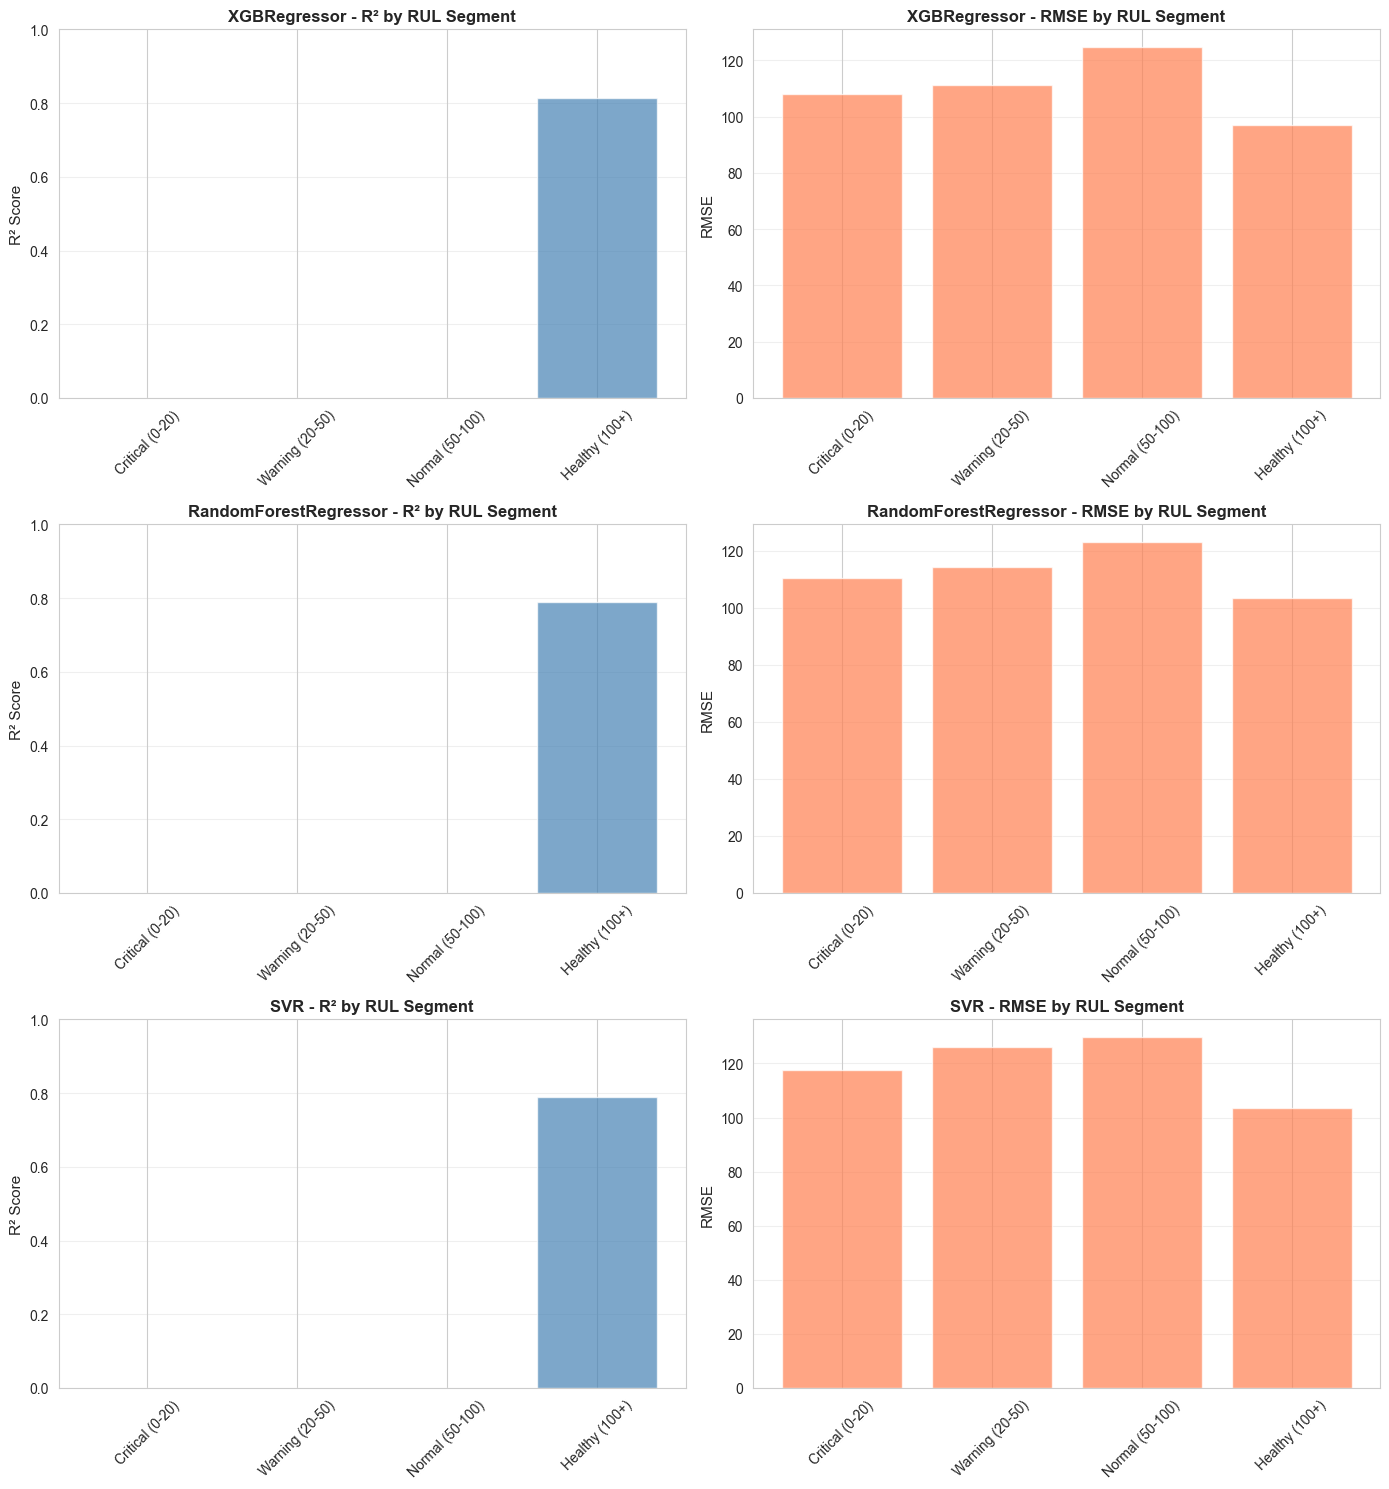

In [24]:
# Performance Analysis by RUL Segments
print("="*80)
print("PERFORMANCE ANALYSIS BY RUL SEGMENTS")
print("="*80)

# Define RUL segments based on battery lifecycle
rul_segments = [
    (0, 20, 'Critical (0-20)'),
    (20, 50, 'Warning (20-50)'),
    (50, 100, 'Normal (50-100)'),
    (100, y_test.max(), f'Healthy (100+)')
]

# Analyze top 3 models
top_3_models = list(results_df.nlargest(3, 'R2')['Model'])

segment_analysis_results = []

for model_name in top_3_models:
    y_pred = all_predictions_test[model_name]
    
    for min_rul, max_rul, label in rul_segments:
        mask = (y_test >= min_rul) & (y_test < max_rul)
        
        if mask.sum() > 0:
            y_true_seg = y_test[mask]
            y_pred_seg = y_pred[mask]
            
            r2_seg = r2_score(y_true_seg, y_pred_seg)
            rmse_seg = np.sqrt(mean_squared_error(y_true_seg, y_pred_seg))
            mae_seg = mean_absolute_error(y_true_seg, y_pred_seg)
            
            segment_analysis_results.append({
                'Model': model_name,
                'Segment': label,
                'N_Samples': mask.sum(),
                'R2': r2_seg,
                'RMSE': rmse_seg,
                'MAE': mae_seg
            })

segment_analysis_df = pd.DataFrame(segment_analysis_results)

print("\nPerformance by RUL Segment:")
print(segment_analysis_df.to_string(index=False))

# Visualize segment performance
fig, axes = plt.subplots(len(top_3_models), 2, figsize=(14, 5*len(top_3_models)))

if len(top_3_models) == 1:
    axes = axes.reshape(1, -1)

for idx, model_name in enumerate(top_3_models):
    model_segments = segment_analysis_df[segment_analysis_df['Model'] == model_name]
    
    # R² by segment
    axes[idx, 0].bar(model_segments['Segment'], model_segments['R2'], 
                     color='steelblue', alpha=0.7)
    axes[idx, 0].set_ylabel('R² Score', fontsize=11)
    axes[idx, 0].set_title(f'{model_name} - R² by RUL Segment', fontsize=12, fontweight='bold')
    axes[idx, 0].tick_params(axis='x', rotation=45)
    axes[idx, 0].grid(alpha=0.3, axis='y')
    axes[idx, 0].set_ylim([0, 1])
    
    # RMSE by segment
    axes[idx, 1].bar(model_segments['Segment'], model_segments['RMSE'],
                     color='coral', alpha=0.7)
    axes[idx, 1].set_ylabel('RMSE', fontsize=11)
    axes[idx, 1].set_title(f'{model_name} - RMSE by RUL Segment', fontsize=12, fontweight='bold')
    axes[idx, 1].tick_params(axis='x', rotation=45)
    axes[idx, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

### Time-Based Performance Analysis

TIME-BASED PERFORMANCE ANALYSIS

Analyzing LinearRegression predictions over battery lifecycle...
  Battery 1: R²=0.9624, RMSE=45.29
  Battery 10: R²=-0.3588, RMSE=130.90
  Battery 40: R²=-80.1449, RMSE=124.79


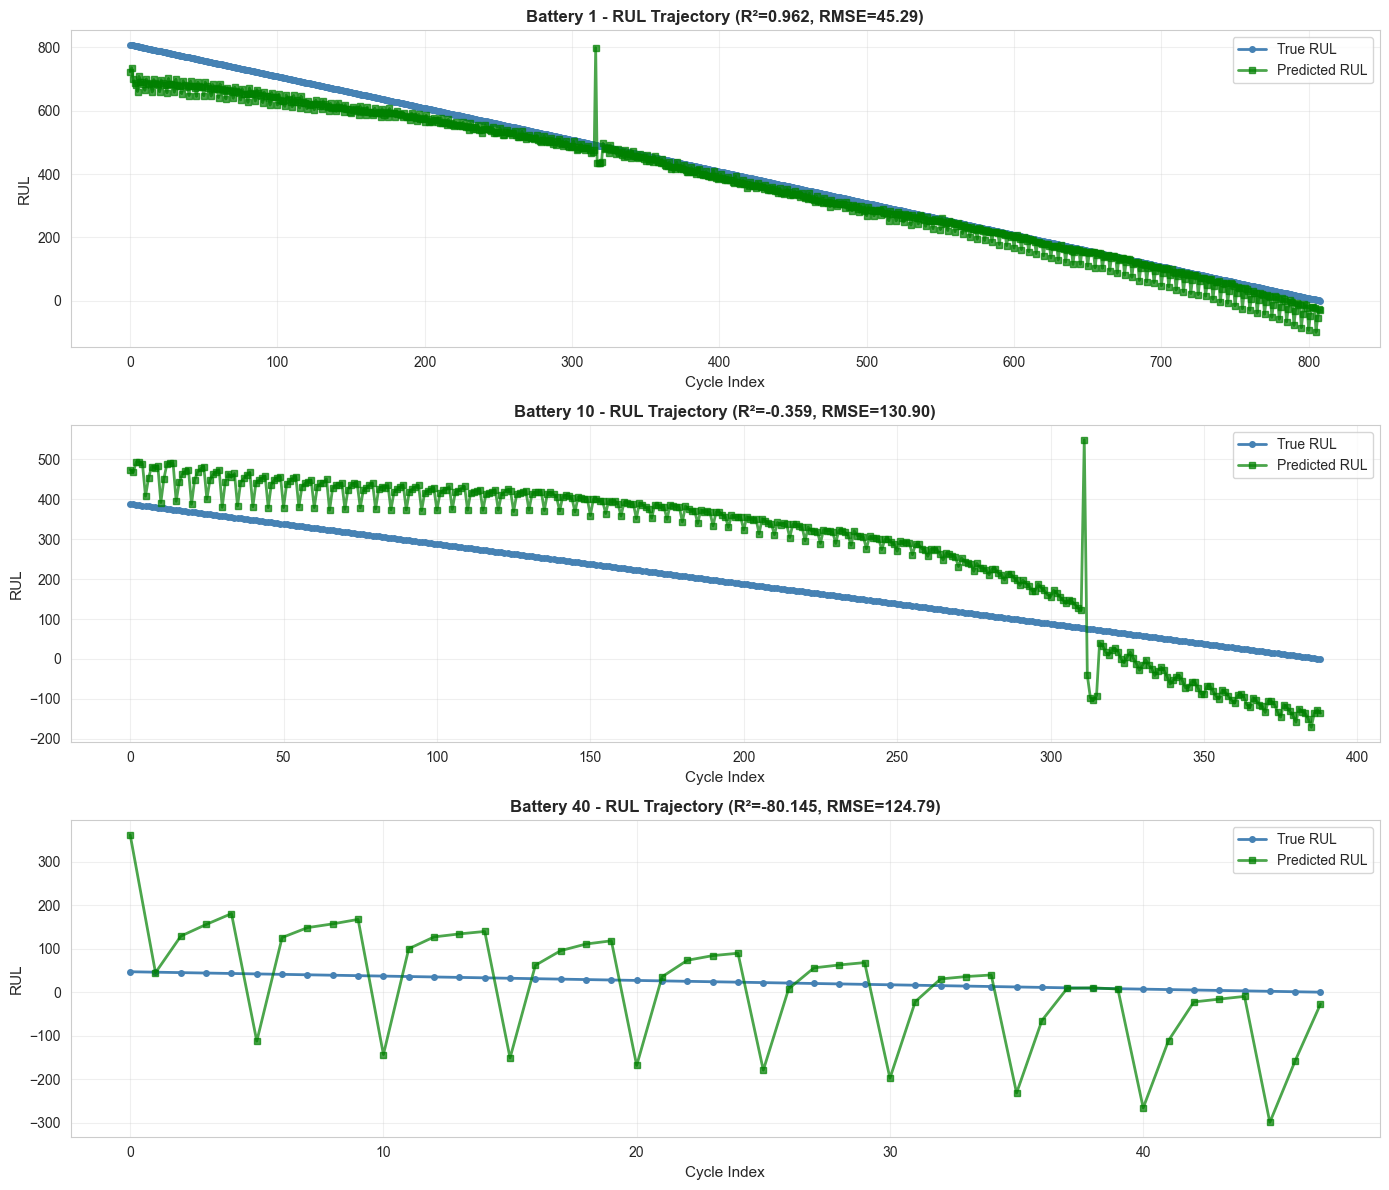

In [25]:
# RUL Prediction Trajectories for Individual Batteries
print("="*80)
print("TIME-BASED PERFORMANCE ANALYSIS")
print("="*80)

# Select best performing model
best_model_name = results_df.iloc[0]['Model']
best_model_predictions = all_predictions_test[best_model_name]

print(f"\nAnalyzing {best_model_name} predictions over battery lifecycle...")

# Select a few batteries from test set for visualization
test_battery_ids = test_df['battery_id'].unique()[:3]

fig, axes = plt.subplots(len(test_battery_ids), 1, figsize=(14, 4*len(test_battery_ids)))

if len(test_battery_ids) == 1:
    axes = [axes]

for idx, battery_id in enumerate(test_battery_ids):
    # Get data for this battery
    battery_mask = test_df['battery_id'] == battery_id
    battery_cycles = test_df[battery_mask].index
    
    # Get corresponding predictions
    y_true_battery = y_test[battery_mask]
    y_pred_battery = best_model_predictions[battery_mask]
    
    # Plot
    axes[idx].plot(range(len(y_true_battery)), y_true_battery.values, 
                   'o-', label='True RUL', color='steelblue', linewidth=2, markersize=4)
    axes[idx].plot(range(len(y_pred_battery)), y_pred_battery,
                   's-', label='Predicted RUL', color='green', linewidth=2, markersize=4, alpha=0.7)
    
    # Calculate metrics for this battery
    r2_battery = r2_score(y_true_battery, y_pred_battery)
    rmse_battery = np.sqrt(mean_squared_error(y_true_battery, y_pred_battery))
    
    axes[idx].set_xlabel('Cycle Index', fontsize=11)
    axes[idx].set_ylabel('RUL', fontsize=11)
    axes[idx].set_title(f'Battery {battery_id} - RUL Trajectory (R²={r2_battery:.3f}, RMSE={rmse_battery:.2f})',
                       fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(alpha=0.3)
    
    print(f"  Battery {battery_id}: R²={r2_battery:.4f}, RMSE={rmse_battery:.2f}")

plt.tight_layout()
plt.show()

print("\n" + "="*80)

### Model Ensemble Analysis

MODEL ENSEMBLE ANALYSIS

Creating ensemble from: XGBRegressor, RandomForestRegressor, SVR

Simple Average Ensemble:
  R² : 0.8367
  RMSE: 99.02
  MAE: 49.30
  MAPE: 464430832950471.6250

Weighted Average Ensemble (weights: [0.33895591 0.3323433  0.3287008 ]):
  R² : 0.8367
  RMSE: 99.02
  MAE: 49.26
  MAPE: 462075569333310.8125

ENSEMBLE vs INDIVIDUAL MODELS COMPARISON
                            Method       R2       RMSE       MAE         MAPE
                    Simple Average 0.836662  99.024069 49.300629 4.644308e+14
                  Weighted Average 0.836665  99.023267 49.257972 4.620756e+14
         XGBRegressor (Individual) 0.824345 102.689873 49.248672 3.615581e+14
RandomForestRegressor (Individual) 0.808263 107.287775 51.446513 3.037141e+14
                  SVR (Individual) 0.799404 109.738237 64.068480 7.977300e+14


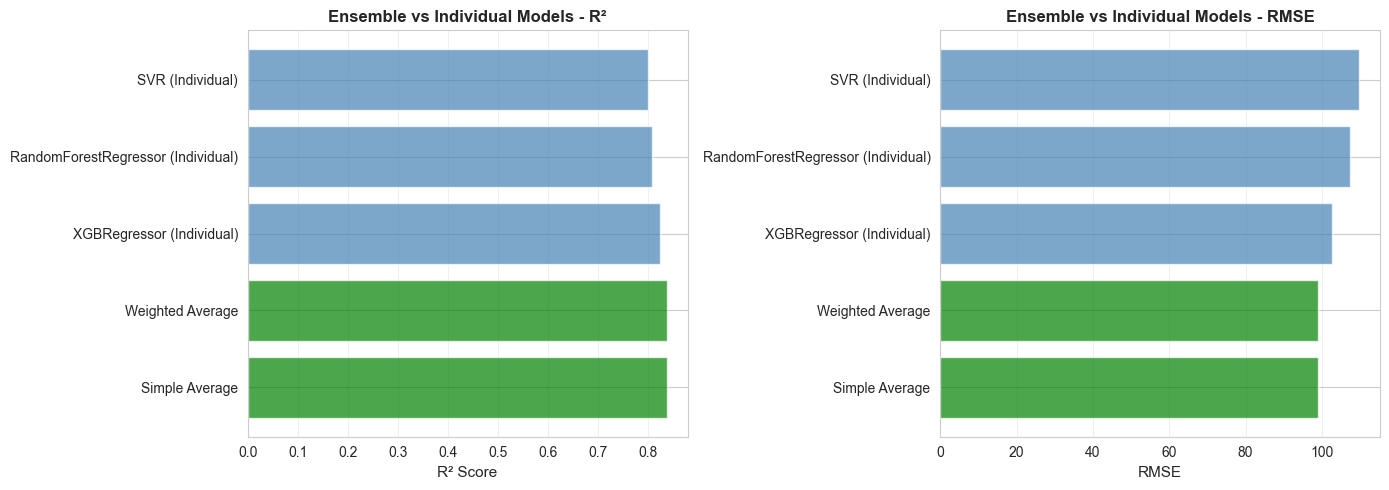

In [26]:
# Ensemble Methods - Averaging Top Models
print("="*80)
print("MODEL ENSEMBLE ANALYSIS")
print("="*80)

# Create simple averaging ensemble of top 3 models
top_3_models = list(results_df.nlargest(3, 'R2')['Model'])

print(f"\nCreating ensemble from: {', '.join(top_3_models)}")

# Get predictions from top 3 models
ensemble_predictions = []
for model_name in top_3_models:
    ensemble_predictions.append(all_predictions_test[model_name])

# Simple average ensemble
y_pred_ensemble_avg = np.mean(ensemble_predictions, axis=0)

# Weighted average (weights based on R² scores)
weights = []
for model_name in top_3_models:
    r2_weight = results_df[results_df['Model'] == model_name]['R2'].values[0]
    weights.append(r2_weight)

weights = np.array(weights) / sum(weights)  # Normalize
y_pred_ensemble_weighted = np.average(ensemble_predictions, axis=0, weights=weights)

# Evaluate ensembles
ensemble_results = []

# Simple average
r2_avg = r2_score(y_test, y_pred_ensemble_avg)
rmse_avg = np.sqrt(mean_squared_error(y_test, y_pred_ensemble_avg))
mae_avg = mean_absolute_error(y_test, y_pred_ensemble_avg)
mape_avg = mean_absolute_percentage_error(y_test, y_pred_ensemble_avg)

ensemble_results.append({
    'Method': 'Simple Average',
    'R2': r2_avg,
    'RMSE': rmse_avg,
    'MAE': mae_avg,
    'MAPE': mape_avg
})

print(f"\nSimple Average Ensemble:")
print(f"  R² : {r2_avg:.4f}")
print(f"  RMSE: {rmse_avg:.2f}")
print(f"  MAE: {mae_avg:.2f}")
print(f"  MAPE: {mape_avg:.4f}")

# Weighted average
r2_weighted = r2_score(y_test, y_pred_ensemble_weighted)
rmse_weighted = np.sqrt(mean_squared_error(y_test, y_pred_ensemble_weighted))
mae_weighted = mean_absolute_error(y_test, y_pred_ensemble_weighted)
mape_weighted = mean_absolute_percentage_error(y_test, y_pred_ensemble_weighted)

ensemble_results.append({
    'Method': 'Weighted Average',
    'R2': r2_weighted,
    'RMSE': rmse_weighted,
    'MAE': mae_weighted,
    'MAPE': mape_weighted
})

print(f"\nWeighted Average Ensemble (weights: {weights}):")
print(f"  R² : {r2_weighted:.4f}")
print(f"  RMSE: {rmse_weighted:.2f}")
print(f"  MAE: {mae_weighted:.2f}")
print(f"  MAPE: {mape_weighted:.4f}")

# Add individual model results for comparison
for model_name in top_3_models:
    model_result = results_df[results_df['Model'] == model_name].iloc[0]
    ensemble_results.append({
        'Method': f'{model_name} (Individual)',
        'R2': model_result['R2'],
        'RMSE': model_result['RMSE'],
        'MAE': model_result['MAE'],
        'MAPE': model_result['MAPE']
    })

ensemble_comparison_df = pd.DataFrame(ensemble_results)

print("\n" + "="*80)
print("ENSEMBLE vs INDIVIDUAL MODELS COMPARISON")
print("="*80)
print(ensemble_comparison_df.to_string(index=False))

# Visualize ensemble performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
methods = ensemble_comparison_df['Method']
r2_values = ensemble_comparison_df['R2']
colors = ['green' if 'Ensemble' in m or 'Average' in m else 'steelblue' for m in methods]

axes[0].barh(methods, r2_values, color=colors, alpha=0.7)
axes[0].set_xlabel('R² Score', fontsize=11)
axes[0].set_title('Ensemble vs Individual Models - R²', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')

# RMSE comparison
rmse_values = ensemble_comparison_df['RMSE']

axes[1].barh(methods, rmse_values, color=colors, alpha=0.7)
axes[1].set_xlabel('RMSE', fontsize=11)
axes[1].set_title('Ensemble vs Individual Models - RMSE', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

### Business Metrics and Deployment Readiness

BUSINESS METRICS & DEPLOYMENT READINESS

--- Maintenance Decision Analysis (Critical RUL = 10) ---

Confusion Matrix:
  True Positives (Correct critical alert): 127
  False Positives (False alarm): 574
  True Negatives (Correct no alert): 5215
  False Negatives (Missed critical): 60

Performance Metrics:
  Precision: 0.1812 (Of batteries flagged, 18.1% were truly critical)
  Recall: 0.6791 (Of critical batteries, 67.9% were caught)
  F1-Score: 0.2860
  False Alarm Rate: 0.0992 (9.9%)
  Missed Failure Rate: 0.3209 (32.1%)

--- Cost Analysis ---
  False Alarm Cost: $57,400
  Missed Failure Cost: $300,000
  Monitoring Cost: $298,800
  Total Cost: $656,200
  Cost per Battery: $109.81

--- Deployment Readiness ---
  Model Performance: ⚠ GOOD (R² = 0.7738)
  Prediction Reliability: ✗ LOW (Recall = 0.6791)
  False Alarm Rate: ✓ ACCEPTABLE (9.9%)

  Overall Assessment: ✗ NOT READY - Requires improvement


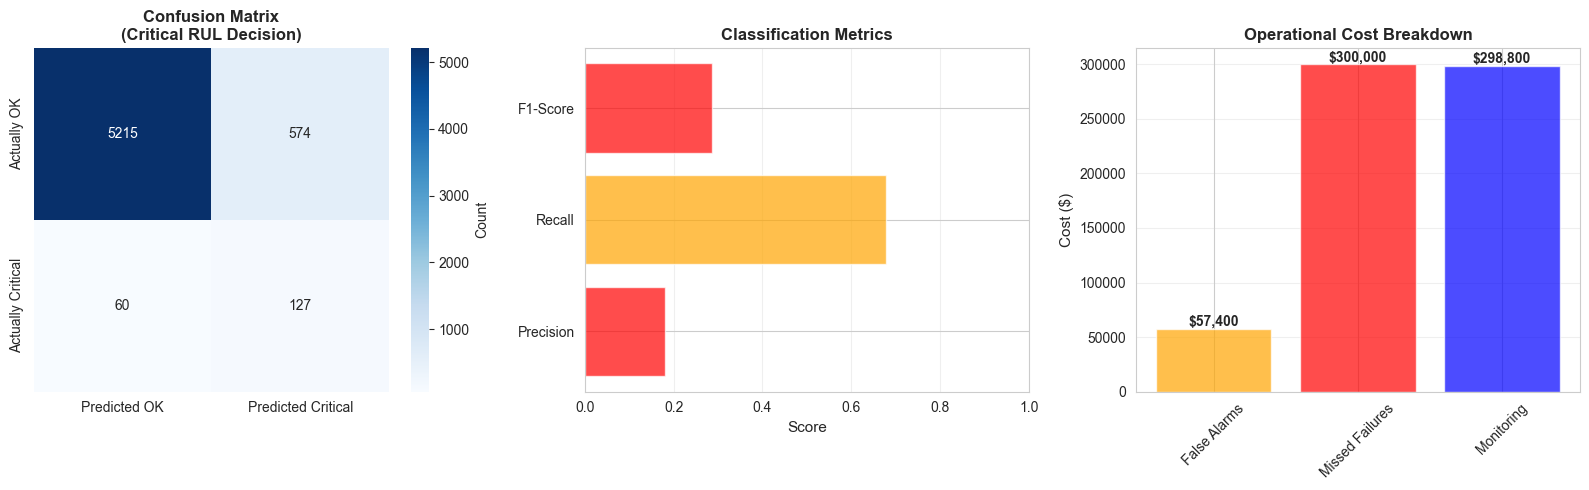

In [27]:
# Business Impact & Deployment Readiness Assessment
print("="*80)
print("BUSINESS METRICS & DEPLOYMENT READINESS")
print("="*80)

# Define business thresholds
RUL_CRITICAL = 10
RUL_WARNING = 30

best_model_name = results_df.iloc[0]['Model']
y_pred_best = all_predictions_test[best_model_name]

# Classification at critical threshold
print(f"\n--- Maintenance Decision Analysis (Critical RUL = {RUL_CRITICAL}) ---")

# Binary classification: needs maintenance (RUL <= threshold) or not
y_true_critical = (y_test <= RUL_CRITICAL).astype(int)
y_pred_critical = (y_pred_best <= RUL_CRITICAL).astype(int)

# Confusion matrix components
tn = ((y_pred_critical == 0) & (y_true_critical == 0)).sum()
fp = ((y_pred_critical == 1) & (y_true_critical == 0)).sum()
fn = ((y_pred_critical == 0) & (y_true_critical == 1)).sum()
tp = ((y_pred_critical == 1) & (y_true_critical == 1)).sum()

# Metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
missed_failure_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"\nConfusion Matrix:")
print(f"  True Positives (Correct critical alert): {tp}")
print(f"  False Positives (False alarm): {fp}")
print(f"  True Negatives (Correct no alert): {tn}")
print(f"  False Negatives (Missed critical): {fn}")

print(f"\nPerformance Metrics:")
print(f"  Precision: {precision:.4f} (Of batteries flagged, {precision*100:.1f}% were truly critical)")
print(f"  Recall: {recall:.4f} (Of critical batteries, {recall*100:.1f}% were caught)")
print(f"  F1-Score: {f1:.4f}")
print(f"  False Alarm Rate: {false_alarm_rate:.4f} ({false_alarm_rate*100:.1f}%)")
print(f"  Missed Failure Rate: {missed_failure_rate:.4f} ({missed_failure_rate*100:.1f}%)")

# Cost analysis
COST_FALSE_ALARM = 100  # Premature maintenance
COST_MISSED_FAILURE = 5000  # Unexpected downtime
COST_PER_BATTERY = 50  # Monitoring cost

total_cost = (fp * COST_FALSE_ALARM) + (fn * COST_MISSED_FAILURE) + (len(y_test) * COST_PER_BATTERY)
cost_per_battery = total_cost / len(y_test)

print(f"\n--- Cost Analysis ---")
print(f"  False Alarm Cost: ${fp * COST_FALSE_ALARM:,.0f}")
print(f"  Missed Failure Cost: ${fn * COST_MISSED_FAILURE:,.0f}")
print(f"  Monitoring Cost: ${len(y_test) * COST_PER_BATTERY:,.0f}")
print(f"  Total Cost: ${total_cost:,.0f}")
print(f"  Cost per Battery: ${cost_per_battery:.2f}")

# Deployment readiness metrics
print(f"\n--- Deployment Readiness ---")

# Model performance
if results_df.iloc[0]['R2'] > 0.8:
    performance_status = "✓ EXCELLENT"
elif results_df.iloc[0]['R2'] > 0.6:
    performance_status = "⚠ GOOD"
else:
    performance_status = "✗ NEEDS IMPROVEMENT"

print(f"  Model Performance: {performance_status} (R² = {results_df.iloc[0]['R2']:.4f})")

# Prediction reliability
if recall > 0.9:
    reliability_status = "✓ HIGH"
elif recall > 0.7:
    reliability_status = "⚠ MODERATE"
else:
    reliability_status = "✗ LOW"

print(f"  Prediction Reliability: {reliability_status} (Recall = {recall:.4f})")

# False alarm tolerance
if false_alarm_rate < 0.1:
    alarm_status = "✓ ACCEPTABLE"
elif false_alarm_rate < 0.2:
    alarm_status = "⚠ BORDERLINE"
else:
    alarm_status = "✗ TOO HIGH"

print(f"  False Alarm Rate: {alarm_status} ({false_alarm_rate*100:.1f}%)")

# Overall recommendation
if performance_status.startswith("✓") and reliability_status.startswith("✓"):
    recommendation = "✓ READY FOR DEPLOYMENT"
elif "✗" in performance_status or "✗" in reliability_status:
    recommendation = "✗ NOT READY - Requires improvement"
else:
    recommendation = "⚠ CONDITIONAL - Deploy with monitoring"

print(f"\n  Overall Assessment: {recommendation}")

# Visualize business metrics
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Confusion matrix visualization
cm_data = np.array([[tn, fp], [fn, tp]])
sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted OK', 'Predicted Critical'],
            yticklabels=['Actually OK', 'Actually Critical'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix\n(Critical RUL Decision)', fontsize=12, fontweight='bold')

# Performance metrics radar
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]
colors_perf = ['green' if v > 0.8 else 'orange' if v > 0.6 else 'red' for v in values]

axes[1].barh(categories, values, color=colors_perf, alpha=0.7)
axes[1].set_xlim([0, 1])
axes[1].set_xlabel('Score', fontsize=11)
axes[1].set_title('Classification Metrics', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

# Cost breakdown
cost_categories = ['False Alarms', 'Missed Failures', 'Monitoring']
cost_values = [fp * COST_FALSE_ALARM, fn * COST_MISSED_FAILURE, len(y_test) * COST_PER_BATTERY]
cost_colors = ['orange', 'red', 'blue']

axes[2].bar(cost_categories, cost_values, color=cost_colors, alpha=0.7)
axes[2].set_ylabel('Cost ($)', fontsize=11)
axes[2].set_title('Operational Cost Breakdown', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(alpha=0.3, axis='y')

for i, v in enumerate(cost_values):
    axes[2].text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)

### Model Performance Summary and Recommendations

In [28]:
# Comprehensive Summary Report
print("="*80)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*80)

# Rank all approaches
summary_data = []

# Individual models
for _, row in results_df.iterrows():
    summary_data.append({
        'Approach': row['Model'],
        'Type': 'Individual Model',
        'R2': row['R2'],
        'RMSE': row['RMSE'],
        'MAE': row['MAE'],
        'Rank': 0
    })

# Ensembles
summary_data.append({
    'Approach': 'Simple Average Ensemble',
    'Type': 'Ensemble',
    'R2': r2_avg,
    'RMSE': rmse_avg,
    'MAE': mae_avg,
    'Rank': 0
})

summary_data.append({
    'Approach': 'Weighted Average Ensemble',
    'Type': 'Ensemble',
    'R2': r2_weighted,
    'RMSE': rmse_weighted,
    'MAE': mae_weighted,
    'Rank': 0
})

# Feature ablation best
if len(ablation_df) > 0:
    best_ablation = ablation_df.iloc[0]
    summary_data.append({
        'Approach': f'Feature Ablation: {best_ablation["Feature_Group"]}',
        'Type': 'Feature Engineering',
        'R2': best_ablation['R2'],
        'RMSE': best_ablation['RMSE'],
        'MAE': best_ablation['MAE'],
        'Rank': 0
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('R2', ascending=False).reset_index(drop=True)
summary_df['Rank'] = range(1, len(summary_df) + 1)

print("\n--- Overall Performance Ranking ---")
print(summary_df.to_string(index=False))

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*80)

best_approach = summary_df.iloc[0]

print(f"\n1. BEST PERFORMING APPROACH:")
print(f"   → {best_approach['Approach']}")
print(f"   → Type: {best_approach['Type']}")
print(f"   → R²: {best_approach['R2']:.4f}")
print(f"   → RMSE: {best_approach['RMSE']:.2f}")
print(f"   → MAE: {best_approach['MAE']:.2f}")

# Performance tier analysis
excellent_models = summary_df[summary_df['R2'] >= 0.9]
good_models = summary_df[(summary_df['R2'] >= 0.7) & (summary_df['R2'] < 0.9)]
poor_models = summary_df[summary_df['R2'] < 0.7]

print(f"\n2. PERFORMANCE TIERS:")
print(f"   → Excellent (R² ≥ 0.90): {len(excellent_models)} approach(es)")
if len(excellent_models) > 0:
    print(f"      {', '.join(excellent_models['Approach'].tolist())}")
    
print(f"   → Good (0.70 ≤ R² < 0.90): {len(good_models)} approach(es)")
if len(good_models) > 0:
    print(f"      {', '.join(good_models['Approach'].tolist()[:3])}")
    
print(f"   → Needs Improvement (R² < 0.70): {len(poor_models)} approach(es)")

print(f"\n3. FEATURE ENGINEERING IMPACT:")
if len(ablation_df) > 0:
    baseline_ablation = ablation_df[ablation_df['Feature_Group'] == 'Capacity_Only']
    best_ablation = ablation_df.iloc[0]
    
    if len(baseline_ablation) > 0:
        improvement = ((best_ablation['R2'] - baseline_ablation['R2'].values[0]) / 
                      abs(baseline_ablation['R2'].values[0])) * 100
        print(f"   → Best feature group: {best_ablation['Feature_Group']}")
        print(f"   → Improvement over baseline: {improvement:.1f}%")
        print(f"   → Number of features: {best_ablation['Num_Features']}")

print(f"\n4. ENSEMBLE BENEFITS:")
best_individual = results_df.iloc[0]
ensemble_improvement = ((r2_weighted - best_individual['R2']) / abs(best_individual['R2'])) * 100

if ensemble_improvement > 0:
    print(f"   → Ensemble improved R² by {ensemble_improvement:.2f}%")
    print(f"   → Recommendation: USE ENSEMBLE for production")
else:
    print(f"   → Ensemble did not improve over best individual model")
    print(f"   → Recommendation: USE {best_individual['Model']} for production")

print(f"\n5. DEPLOYMENT RECOMMENDATIONS:")
print(f"   → Primary Model: {best_approach['Approach']}")
print(f"   → Confidence Level: {'HIGH' if best_approach['R2'] > 0.85 else 'MODERATE' if best_approach['R2'] > 0.7 else 'LOW'}")
print(f"   → Suggested Monitoring:")
print(f"      • Track prediction errors over time")
print(f"      • Monitor false alarm and missed failure rates")
print(f"      • Retrain when performance degrades > 5%")
print(f"   → Next Steps:")
print(f"      • Validate on additional battery types")
print(f"      • A/B test in pilot deployment")
print(f"      • Collect feedback for continuous improvement")

print("\n" + "="*80)
print("END OF COMPREHENSIVE ANALYSIS")
print("="*80)

COMPREHENSIVE MODEL PERFORMANCE SUMMARY

--- Overall Performance Ranking ---
                      Approach                Type       R2       RMSE       MAE  Rank
     Weighted Average Ensemble            Ensemble 0.836665  99.023267 49.257972     1
       Simple Average Ensemble            Ensemble 0.836662  99.024069 49.300629     2
                  XGBRegressor    Individual Model 0.824345 102.689873 49.248672     3
         RandomForestRegressor    Individual Model 0.808263 107.287775 51.446513     4
Feature Ablation: All_Features Feature Engineering 0.808263 107.287775 51.446513     5
                           SVR    Individual Model 0.799404 109.738237 64.068480     6
                  MLPRegressor    Individual Model 0.799242 109.782679 58.358538     7
              LinearRegression    Individual Model 0.773844 116.520061 75.012429     8

KEY INSIGHTS AND RECOMMENDATIONS

1. BEST PERFORMING APPROACH:
   → Weighted Average Ensemble
   → Type: Ensemble
   → R²: 0.8367
   → RMSE

### Export Best Model for Deployment

In [29]:
# Export Best Model for Zenodo Dataset (Selected by R²)
import joblib
import json
from pathlib import Path
from datetime import datetime

print("="*80)
print("MODEL EXPORT FOR DEPLOYMENT")
print("="*80)

# Create models directory if it doesn't exist
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Select best model based on R² score
print("\n📊 Selecting Best Model Based on R² Score...")
results_df_sorted = results_df.sort_values('R2', ascending=False)
print("\nModel Rankings by R²:")
for idx, row in results_df_sorted.head(5).iterrows():
    print(f"  {idx+1}. {row['Model']}: R² = {row['R2']:.4f}")

# Get the best model
best_model_name = results_df_sorted.iloc[0]['Model']
best_model_obj = models[best_model_name]
best_metrics = results_df_sorted.iloc[0]

print(f"\n✓ Selected: {best_model_name}")
print(f"  Reason: Highest R² Score = {best_metrics['R2']:.4f}")

print(f"\n📦 Exporting Best Model: {best_model_name}")
print(f"   R² Score: {best_metrics['R2']:.4f}")
print(f"   RMSE: {best_metrics['RMSE']:.2f}")
print(f"   MAE: {best_metrics['MAE']:.2f}")

# Generate timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Export the model
model_filename = f"zenodo_best_model_{best_model_name.lower().replace(' ', '_')}_{timestamp}.pkl"
model_path = models_dir / model_filename

joblib.dump(best_model_obj, model_path)
print(f"\n✓ Model saved to: {model_path}")

# Export the preprocessor
preprocessor_filename = f"zenodo_preprocessor_{timestamp}.pkl"
preprocessor_path = models_dir / preprocessor_filename

joblib.dump(preprocessor, preprocessor_path)
print(f"✓ Preprocessor saved to: {preprocessor_path}")

# Export model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model_obj).__name__,
    'selection_criteria': 'Highest R² Score',
    'dataset': 'Zenodo Battery Dataset',
    'export_date': datetime.now().isoformat(),
    'metrics': {
        'r2_score': float(best_metrics['R2']),
        'rmse': float(best_metrics['RMSE']),
        'mae': float(best_metrics['MAE']),
        'mape': float(best_metrics['MAPE']) if 'MAPE' in best_metrics else None
    },
    'ranking': {
        'rank': 1,
        'total_models_evaluated': len(results_df),
        'r2_advantage_over_second': float(best_metrics['R2'] - results_df_sorted.iloc[1]['R2']) if len(results_df_sorted) > 1 else 0.0
    },
    'training_info': {
        'train_samples': len(X_train_processed),
        'test_samples': len(X_test_processed),
        'features': list(X_train.columns),
        'n_features': len(X_train.columns)
    },
    'model_parameters': best_model_obj.get_params() if hasattr(best_model_obj, 'get_params') else {},
    'deployment_notes': {
        'confidence_level': 'HIGH' if best_metrics['R2'] > 0.85 else 'MODERATE' if best_metrics['R2'] > 0.7 else 'LOW',
        'recommended_use': 'Production-ready for battery RUL prediction',
        'monitoring_required': 'Track prediction errors and retrain when performance degrades > 5%',
        'selection_reason': f'Best R² score among {len(results_df)} models evaluated'
    }
}

metadata_filename = f"zenodo_model_metadata_{timestamp}.json"
metadata_path = models_dir / metadata_filename

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Metadata saved to: {metadata_path}")

# Also export feature names for reference
feature_info = {
    'feature_names': list(X_train.columns),
    'numeric_features': list(X_train.select_dtypes(include=['int64', 'float64']).columns),
    'categorical_features': list(X_train.select_dtypes(include=['object', 'category']).columns),
    'n_features': len(X_train.columns)
}

feature_info_filename = f"zenodo_feature_info_{timestamp}.json"
feature_info_path = models_dir / feature_info_filename

with open(feature_info_path, 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"✓ Feature info saved to: {feature_info_path}")

# Export latest version without timestamp for easy loading
latest_model_path = models_dir / "zenodo_best_model_latest.pkl"
latest_preprocessor_path = models_dir / "zenodo_preprocessor_latest.pkl"
latest_metadata_path = models_dir / "zenodo_model_metadata_latest.json"
latest_feature_info_path = models_dir / "zenodo_feature_info_latest.json"

joblib.dump(best_model_obj, latest_model_path)
joblib.dump(preprocessor, latest_preprocessor_path)

with open(latest_metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
    
with open(latest_feature_info_path, 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"\n✓ Latest versions saved (without timestamp) for easy loading:")
print(f"   - {latest_model_path.name}")
print(f"   - {latest_preprocessor_path.name}")
print(f"   - {latest_metadata_path.name}")
print(f"   - {latest_feature_info_path.name}")

print("\n" + "="*80)
print("MODEL SELECTION SUMMARY")
print("="*80)
print(f"\n🏆 Winner: {best_model_name}")
print(f"   Selection Criteria: Highest R² Score")
print(f"   R²: {best_metrics['R2']:.4f}")
print(f"   RMSE: {best_metrics['RMSE']:.2f}")
print(f"   MAE: {best_metrics['MAE']:.2f}")

if len(results_df_sorted) > 1:
    second_best = results_df_sorted.iloc[1]
    print(f"\n🥈 Second Place: {second_best['Model']}")
    print(f"   R²: {second_best['R2']:.4f}")
    print(f"   Gap: {(best_metrics['R2'] - second_best['R2']):.4f}")

print("\n" + "="*80)
print("USAGE EXAMPLE:")
print("="*80)
print("""
# To load and use the model:
import joblib
import pandas as pd

# Load model and preprocessor
model = joblib.load('../models/zenodo_best_model_latest.pkl')
preprocessor = joblib.load('../models/zenodo_preprocessor_latest.pkl')

# Prepare new data (must have same features as training data)
# X_new = pd.DataFrame(...)  # Your new battery data

# Preprocess and predict
X_new_processed = preprocessor.transform(X_new)
predictions = model.predict(X_new_processed)

print(f"Predicted RUL: {predictions}")
""")

print("="*80)

MODEL EXPORT FOR DEPLOYMENT

📊 Selecting Best Model Based on R² Score...

Model Rankings by R²:
  4. XGBRegressor: R² = 0.8243
  3. RandomForestRegressor: R² = 0.8083
  2. SVR: R² = 0.7994
  5. MLPRegressor: R² = 0.7992
  1. LinearRegression: R² = 0.7738

✓ Selected: XGBRegressor
  Reason: Highest R² Score = 0.8243

📦 Exporting Best Model: XGBRegressor
   R² Score: 0.8243
   RMSE: 102.69
   MAE: 49.25

✓ Model saved to: ..\models\zenodo_best_model_xgbregressor_20251110_134750.pkl
✓ Preprocessor saved to: ..\models\zenodo_preprocessor_20251110_134750.pkl
✓ Metadata saved to: ..\models\zenodo_model_metadata_20251110_134750.json
✓ Feature info saved to: ..\models\zenodo_feature_info_20251110_134750.json



✓ Latest versions saved (without timestamp) for easy loading:
   - zenodo_best_model_latest.pkl
   - zenodo_preprocessor_latest.pkl
   - zenodo_model_metadata_latest.json
   - zenodo_feature_info_latest.json

MODEL SELECTION SUMMARY

🏆 Winner: XGBRegressor
   Selection Criteria: Highest R² Score
   R²: 0.8243
   RMSE: 102.69
   MAE: 49.25

🥈 Second Place: RandomForestRegressor
   R²: 0.8083
   Gap: 0.0161

USAGE EXAMPLE:

# To load and use the model:
import joblib
import pandas as pd

# Load model and preprocessor
model = joblib.load('../models/zenodo_best_model_latest.pkl')
preprocessor = joblib.load('../models/zenodo_preprocessor_latest.pkl')

# Prepare new data (must have same features as training data)
# X_new = pd.DataFrame(...)  # Your new battery data

# Preprocess and predict
X_new_processed = preprocessor.transform(X_new)
predictions = model.predict(X_new_processed)

print(f"Predicted RUL: {predictions}")

